In [1]:

import os,torch,random
from catemb import CatEmb
from catemb.utils import link_lig_to_metal,set_seed
import numpy as np
import pandas as pd
from rdkit import Chem
from rxnemb import RXNEMB
from rdkit.Chem.Draw import IPythonConsole
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from copy import deepcopy
from glob import glob
from scipy.stats import pearsonr

def random_init(cat_score_lst, leave_best_topk=3, batch_size=5, rand_seed=42):
    print(f"best {leave_best_topk} catalyst ddG:",[item[1] for item in cat_score_lst[-leave_best_topk:]])
    if leave_best_topk > 0:
        target_cat = cat_score_lst[-leave_best_topk:]     ## Top-k
        remain_cat = cat_score_lst[:-leave_best_topk]     ## 43 - k
    else:
        target_cat = []
        remain_cat = cat_score_lst
    shuffle_idx = np.arange(len(remain_cat))
    np.random.seed(rand_seed)
    np.random.shuffle(shuffle_idx)
    start_idx_lst = shuffle_idx[:batch_size]                 ## 5 from 40
    pool_idx_lst = shuffle_idx[batch_size:]                ## 35
    start_cat = [remain_cat[idx] for idx in start_idx_lst]
    pool_cat = [remain_cat[idx] for idx in pool_idx_lst] + target_cat
    start_score = np.array([cat[1] for cat in start_cat])


    ######
    cur_cat = deepcopy(start_cat)
    cur_score = deepcopy(start_score)
    if len(cur_score) > 0:
        max_score = np.max(cur_score)
    else:
        max_score = 0
    print(f"{len(pool_cat)}, {len(cur_cat)}")
    print(f"Max score: {max_score:.4f}, {len(cur_score)}")
    
    return cur_score,cur_cat,pool_cat

def recommend_by_dist(catemb_calc,cur_score,cur_cat,pool_cat,batch_size=5,best_n=1):
    ######
    cur_cat_smi_lst = [cur[0] for cur in cur_cat]
    pool_cat_smi_lst = [pool[0] for pool in pool_cat]
    
    best_topk_cat_idx_lst = np.abs(cur_score).argsort()[::-1][:best_n]     # best one from existed catalysts
                        
    cur_cat_desc_arr = catemb_calc.gen_desc(cur_cat_smi_lst)
    pool_cat_desc_arr = catemb_calc.gen_desc(pool_cat_smi_lst)


    best_existed_cat_desc_arr = cur_cat_desc_arr[best_topk_cat_idx_lst]
    dist_of_pool_to_best = np.array([np.linalg.norm(arr - pool_cat_desc_arr,axis=1) for arr in best_existed_cat_desc_arr])


    recommend_cat_idx_lst_by_dist = dist_of_pool_to_best.sum(0).argsort()[:batch_size]
    recommend_cat = [pool_cat[idx] for idx in recommend_cat_idx_lst_by_dist]
    recommend_score = np.array([cat[1] for cat in recommend_cat])

    cur_cat = cur_cat + recommend_cat
    cur_cat_smi_lst = [cat[0] for cat in cur_cat]
    cur_score = np.concatenate([cur_score,recommend_score])
    pool_cat = [cat for idx,cat in enumerate(pool_cat) if not cat[0] in cur_cat_smi_lst]
    pool_cat_smi_lst = [cat[0] for cat in pool_cat]
    print(f"{len(pool_cat)}, {len(cur_cat)}")
    print(f"Max score: {np.max(cur_score):.4f}, {len(cur_score)}")
    return cur_score,cur_cat,pool_cat

def recommend_by_random(cur_score,cur_cat,pool_cat,batch_size=5):
    ######
    chose_idx_lst = np.random.choice(len(pool_cat),batch_size,replace=False)
    recommend_cat = [pool_cat[idx] for idx in chose_idx_lst]
    recommend_score = np.array([cat[1] for cat in recommend_cat])

    cur_cat = cur_cat + recommend_cat
    cur_cat_smi_lst = [cat[0] for cat in cur_cat]
    cur_score = np.concatenate([cur_score,recommend_score])
    pool_cat = [cat for idx,cat in enumerate(pool_cat) if not cat[0] in cur_cat_smi_lst]
    print(f"{len(pool_cat)}, {len(cur_cat)}")
    print(f"Max score: {np.max(cur_score):.4f}, {len(cur_score)}")
    return cur_score,cur_cat,pool_cat

def clear_atom_map(smiles):
    mol = Chem.MolFromSmiles(smiles)
    for atom in mol.GetAtoms():
        if atom.HasProp('molAtomMapNumber'):
            atom.ClearProp('molAtomMapNumber')
    return Chem.MolToSmiles(mol)
def gen_mix_rxn_smi(rxn_smi):
    mix_rxn_smi = f'{clear_atom_map(".".join(rxn_smi.split(">")[:2]))}>>{clear_atom_map(rxn_smi.split(">")[2])}'
    return mix_rxn_smi
'''def gen_full_rxn_desc(data_df):
    """
    for N,N'-Dioxide/metal complex catalyzed Michael Addiditon
    """
    rxn_act_smi_lst,rxn_smi_lst,dtv_act_rxn_smi_lst,dtv_rxn_smi_lst = data_df['rxn_active_smiles'].to_list(),data_df['rxn_smiles'],data_df['dative_active_rxn_smiles'],data_df['dative_rxn_smiles'].to_list()
    mix_rxn_act_smi_lst = [gen_mix_rxn_smi(rxn_smi) for rxn_smi in rxn_act_smi_lst]
    mix_rxn_smi_lst = [gen_mix_rxn_smi(rxn_smi) for rxn_smi in rxn_smi_lst]
    cat_smi_lst = data_df['catalyst_smiles'].to_list()

    rxn_desc = rxnemb_calc.gen_rxn_emb(mix_rxn_smi_lst)
    cat_desc = catemb_calc.gen_desc(cat_smi_lst)
    return np.concatenate([rxn_desc,cat_desc],axis=1)'''
def gen_full_rxn_desc2(data_df,rxnemb_calc,catemb_calc):
    #data_df = data_df.fillna("")
    rct_smi_lst, sol_smi_lst, cat_smi_lst, add_smi_lst, pdt_smi_lst = data_df['reactants_couples_smiles'],data_df['solvents_smiles'].fillna("ClCCl"),data_df['catalyst_smiles'],data_df['additives_smiles'].fillna("CCN(CC)CC"),data_df['products_smiles']
    rxn_smi_lst = [f"{rct}>>{pdt}" for rct,pdt in zip(rct_smi_lst,pdt_smi_lst)]
    rxn_desc = rxnemb_calc.gen_rxn_emb(rxn_smi_lst)
    cat_desc = catemb_calc.gen_desc(cat_smi_lst)
    sol_desc = catemb_calc.gen_desc(sol_smi_lst)
    return np.round(np.concatenate([rxn_desc,cat_desc,sol_desc,],axis=1),2)
    
    
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 400, 400
random_seed = 42
set_seed(random_seed)

/opt/conda/envs/catemb/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_path = '../code/save_model/260202-0640h_equif_plat_lr1e-4_decay_step5_temp0.1_EBM_dot_prod_xtbopt62755_equif_first_dim32_cl_kl_e_111_ln'
# '../code/save_model/260203-0316h_equif_plat_lr2e-4_decay_step5_temp0.1_EBM_dot_prod_xtbopt62755_equif_first_dim64_cl_kl_e_111_ln_10epoch' best
# '../code/save_model/260202-0646h_equif_plat_lr1e-4_decay_step5_temp0.1_EBM_dot_prod_xtbopt62755_equif_first_dim32_cl_kl_e_111_noln_copy' # 7, 13, 19
# '../code/save_model/260202-1312h_equif_plat_lr2e-4_decay_step5_temp0.1_EBM_dot_prod_xtbopt62755_equif_first_dim32_cl_kl_e_111_ln_copy' # 5, 11, 12
# '../code/save_model/260202-0640h_equif_plat_lr1e-4_decay_step5_temp0.1_EBM_dot_prod_xtbopt62755_equif_first_dim32_cl_kl_e_111_ln_cp' # 6, 50+, 50+
catemb_calc = CatEmb(model_path=model_path, device='cpu')
#catemb_calc2 = CatEmb(model_path='../code/catemb/model_path/dim64LN', device='cpu')
#catemb_calc3 = CatEmb(model_path='../code/catemb/model_path/dim64noLN', device='cpu')
rxnemb_calc = RXNEMB(device='cpu')

In [3]:
model1 = RandomForestRegressor(n_estimators=100,random_state=random_seed,n_jobs=-1)
model2 = ExtraTreesRegressor(n_estimators=100,random_state=random_seed,n_jobs=-1)
model3 = XGBRegressor(n_estimators=100,random_state=random_seed,n_jobs=-1)

### NNdioxide-asymMichael

#### 随机划分

In [32]:
fold5_train_files = sorted(glob("../dataset/NNdioxide-asymMichael/data/5-folds/train*.csv"),key=lambda x:int(os.path.basename(x).split(".")[0].split("_")[-1]))
full_test_pred_rf = []
full_test_pred_et = []
full_test_pred_xgb = []
full_test_truth = []
for idx,train_file in enumerate(fold5_train_files):
    test_file = train_file.replace("train","test")
    train_data = pd.read_csv(train_file)
    test_data = pd.read_csv(test_file)
    train_desc = gen_full_rxn_desc2(train_data,rxnemb_calc,catemb_calc)
    test_desc = gen_full_rxn_desc2(test_data,rxnemb_calc,catemb_calc)
    train_label = train_data['ddG (kcal/mol)'].to_numpy()
    test_label = test_data['ddG (kcal/mol)'].to_numpy()
    #model1.fit(train_desc,train_label)
    model2.fit(train_desc,train_label)
    #model3.fit(train_desc,train_label)
    #rf_pred = model1.predict(test_desc)
    et_pred = model2.predict(test_desc)
    #xgb_pred = model3.predict(test_desc)
    #full_test_pred_rf.append(rf_pred)
    full_test_pred_et.append(et_pred)
    #full_test_pred_xgb.append(xgb_pred)
    full_test_truth.append(test_label)
    #r2_rf = r2_score(test_label,rf_pred)
    r2_et = r2_score(test_label,et_pred)
    #r2_xgb = r2_score(test_label,xgb_pred)
    
    print(f"Fold-{idx+1} ET is {r2_et:.4f}")
#full_r2_rf = r2_score(np.concatenate(full_test_truth),np.concatenate(full_test_pred_rf))
full_r2_et = r2_score(np.concatenate(full_test_truth),np.concatenate(full_test_pred_et))
#full_r2_xgb = r2_score(np.concatenate(full_test_truth),np.concatenate(full_test_pred_xgb))
print(f"Full R2 score of ET is {full_r2_et:.4f}")
    

Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 1320/1320 [00:02<00:00, 584.15it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 1320/1320 [00:01<00:00, 697.00it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 11/11 [00:02<00:00,  4.49it/s]
Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 331/331 [00:00<00:00, 594.74it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 331/331 [00:00<00:00, 671.48it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 3/3 [00:00<00:00,  5.56it/s]


Fold-1 ET is 0.7342


Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 1321/1321 [00:02<00:00, 598.56it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 1321/1321 [00:01<00:00, 687.41it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 11/11 [00:02<00:00,  4.07it/s]
Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 330/330 [00:00<00:00, 566.35it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 330/330 [00:00<00:00, 629.50it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 3/3 [00:00<00:00,  6.41it/s]


Fold-2 ET is 0.7434


Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 1321/1321 [00:02<00:00, 639.99it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 1321/1321 [00:01<00:00, 742.21it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 11/11 [00:02<00:00,  5.20it/s]
Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 330/330 [00:00<00:00, 750.93it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 330/330 [00:00<00:00, 830.03it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 3/3 [00:00<00:00,  3.22it/s]


Fold-3 ET is 0.6406


Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 1321/1321 [00:01<00:00, 759.05it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 1321/1321 [00:01<00:00, 831.78it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 11/11 [00:04<00:00,  2.31it/s]
Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 330/330 [00:00<00:00, 601.81it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 330/330 [00:00<00:00, 672.68it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 3/3 [00:01<00:00,  2.64it/s]


Fold-4 ET is 0.7268


Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 1321/1321 [00:01<00:00, 663.19it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 1321/1321 [00:01<00:00, 834.73it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 11/11 [00:05<00:00,  2.01it/s]
Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 330/330 [00:00<00:00, 738.78it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 330/330 [00:00<00:00, 782.93it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 3/3 [00:00<00:00,  3.02it/s]


Fold-5 ET is 0.7468
Full R2 score of ET is 0.7191


In [33]:
mae = mean_absolute_error(np.concatenate(full_test_truth),np.concatenate(full_test_pred_et))
r2 = r2_score(np.concatenate(full_test_truth),np.concatenate(full_test_pred_et))
prsr = pearsonr(np.concatenate(full_test_truth),np.concatenate(full_test_pred_et))[0]
print(f"Random, MAE: {mae}, R2: {r2}, Pearson R: {prsr}")

Random, MAE: 0.32205886491575314, R2: 0.7191272203564596, Pearson R: 0.848563206244904


#### OOS

In [53]:
oos_train_files = sorted(glob("../dataset/NNdioxide-asymMichael/data/OOS/train*.csv"),key=lambda x:int(os.path.basename(x).split(".")[0].split("_")[-1]))
full_test_pred_rf = []
full_test_pred_et = []
full_test_pred_xgb = []
full_test_truth = []
set_seed(random_seed)
for idx,train_file in enumerate(oos_train_files):
    test_file = train_file.replace("train","test")
    train_data = pd.read_csv(train_file)
    test_data = pd.read_csv(test_file)
    train_desc = gen_full_rxn_desc2(train_data,rxnemb_calc,catemb_calc)
    test_desc = gen_full_rxn_desc2(test_data,rxnemb_calc,catemb_calc)
    train_label = train_data['ddG (kcal/mol)'].to_numpy()
    test_label = test_data['ddG (kcal/mol)'].to_numpy()
    #model1.fit(train_desc,train_label)
    model2.fit(train_desc,train_label)
    #model3.fit(train_desc,train_label)
    #rf_pred = model1.predict(test_desc)
    et_pred = model2.predict(test_desc)
    #xgb_pred = model3.predict(test_desc)
    #full_test_pred_rf.append(rf_pred)
    full_test_pred_et.append(et_pred)
    #full_test_pred_xgb.append(xgb_pred)
    full_test_truth.append(test_label)
    #r2_rf = r2_score(test_label,rf_pred)
    r2_et = r2_score(test_label,et_pred)
    #r2_xgb = r2_score(test_label,xgb_pred)
    
    print(f"Fold-{idx+1} ET is {r2_et:.4f}")
#full_r2_rf = r2_score(np.concatenate(full_test_truth),np.concatenate(full_test_pred_rf))
full_r2_et = r2_score(np.concatenate(full_test_truth),np.concatenate(full_test_pred_et))
#full_r2_xgb = r2_score(np.concatenate(full_test_truth),np.concatenate(full_test_pred_xgb))
print(f"Full R2 score of ET is {full_r2_et:.4f}")

Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 1634/1634 [00:02<00:00, 747.05it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 1634/1634 [00:01<00:00, 826.69it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 13/13 [00:06<00:00,  2.13it/s]
Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 17/17 [00:00<00:00, 656.55it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 17/17 [00:00<00:00, 715.74it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 1/1 [00:00<00:00, 14.83it/s]


Fold-1 ET is -0.6542


Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 1635/1635 [00:02<00:00, 601.34it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 1635/1635 [00:01<00:00, 824.82it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 13/13 [00:05<00:00,  2.22it/s]
Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 16/16 [00:00<00:00, 675.59it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 16/16 [00:00<00:00, 734.83it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 1/1 [00:00<00:00, 38.23it/s]


Fold-2 ET is -0.5865


Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 1621/1621 [00:02<00:00, 743.97it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 1621/1621 [00:01<00:00, 825.79it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 13/13 [00:06<00:00,  1.96it/s]
Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 30/30 [00:00<00:00, 474.31it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 30/30 [00:00<00:00, 488.91it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 1/1 [00:00<00:00, 14.85it/s]


Fold-3 ET is -0.2608


Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 1635/1635 [00:02<00:00, 757.92it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 1635/1635 [00:01<00:00, 824.08it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 13/13 [00:06<00:00,  2.16it/s]
Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 16/16 [00:00<00:00, 449.20it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 16/16 [00:00<00:00, 490.51it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 1/1 [00:00<00:00, 34.62it/s]


Fold-4 ET is -0.2161


Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 1632/1632 [00:02<00:00, 748.62it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 1632/1632 [00:02<00:00, 645.09it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]
Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 19/19 [00:00<00:00, 583.81it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 19/19 [00:00<00:00, 611.96it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 1/1 [00:00<00:00, 10.61it/s]


Fold-5 ET is -1.8736


Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 1595/1595 [00:02<00:00, 758.06it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 1595/1595 [00:01<00:00, 835.85it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 13/13 [00:03<00:00,  3.80it/s]
Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 56/56 [00:00<00:00, 928.88it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 56/56 [00:00<00:00, 1016.83it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 1/1 [00:00<00:00, 26.94it/s]


Fold-6 ET is 0.1699


Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 1633/1633 [00:02<00:00, 760.98it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 1633/1633 [00:01<00:00, 840.96it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]
Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 18/18 [00:00<00:00, 305.59it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 18/18 [00:00<00:00, 839.63it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 1/1 [00:00<00:00, 23.93it/s]


Fold-7 ET is -1.1790


Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 1627/1627 [00:02<00:00, 760.02it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 1627/1627 [00:01<00:00, 838.51it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 13/13 [00:06<00:00,  2.09it/s]
Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 24/24 [00:00<00:00, 618.67it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 24/24 [00:00<00:00, 821.25it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 1/1 [00:00<00:00, 33.10it/s]


Fold-8 ET is -6.3192


Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 1632/1632 [00:02<00:00, 635.49it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 1632/1632 [00:01<00:00, 832.94it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 13/13 [00:05<00:00,  2.23it/s]
Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 19/19 [00:00<00:00, 608.64it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 19/19 [00:00<00:00, 816.29it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 1/1 [00:00<00:00, 20.13it/s]


Fold-9 ET is -0.1437


Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 1634/1634 [00:02<00:00, 701.92it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 1634/1634 [00:01<00:00, 838.10it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]
Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 17/17 [00:00<00:00, 606.67it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 17/17 [00:00<00:00, 664.76it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 1/1 [00:00<00:00, 33.92it/s]


Fold-10 ET is -3.2563


Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 1629/1629 [00:02<00:00, 670.31it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 1629/1629 [00:02<00:00, 709.07it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 13/13 [00:06<00:00,  2.00it/s]
Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 22/22 [00:00<00:00, 421.52it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 22/22 [00:00<00:00, 424.81it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 1/1 [00:00<00:00, 33.21it/s]


Fold-11 ET is -0.2221


Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 1627/1627 [00:02<00:00, 674.83it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 1627/1627 [00:01<00:00, 820.22it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 13/13 [00:05<00:00,  2.19it/s]
Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 24/24 [00:00<00:00, 628.03it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 24/24 [00:00<00:00, 664.03it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 1/1 [00:00<00:00, 38.10it/s]


Fold-12 ET is -0.7729


Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 1633/1633 [00:02<00:00, 747.92it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 1633/1633 [00:01<00:00, 833.08it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 13/13 [00:05<00:00,  2.17it/s]
Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 18/18 [00:00<00:00, 864.80it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 18/18 [00:00<00:00, 995.94it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 1/1 [00:00<00:00, 35.93it/s]


Fold-13 ET is -1.2136


Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 1630/1630 [00:02<00:00, 761.62it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 1630/1630 [00:02<00:00, 747.54it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]
Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 21/21 [00:00<00:00, 523.55it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 21/21 [00:00<00:00, 750.98it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 1/1 [00:00<00:00, 19.23it/s]


Fold-14 ET is -1.0537


Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 1630/1630 [00:02<00:00, 712.17it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 1630/1630 [00:02<00:00, 773.24it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 13/13 [00:05<00:00,  2.47it/s]
Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 21/21 [00:00<00:00, 680.75it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 21/21 [00:00<00:00, 978.23it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 1/1 [00:00<00:00, 14.76it/s]


Fold-15 ET is -3.9513


Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 1598/1598 [00:02<00:00, 753.97it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 1598/1598 [00:01<00:00, 828.26it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 13/13 [00:05<00:00,  2.27it/s]
Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 53/53 [00:00<00:00, 1099.23it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 53/53 [00:00<00:00, 1471.81it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 1/1 [00:00<00:00, 29.42it/s]


Fold-16 ET is -1.1818


Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 1628/1628 [00:02<00:00, 761.04it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 1628/1628 [00:01<00:00, 843.31it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 13/13 [00:05<00:00,  2.46it/s]
Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 23/23 [00:00<00:00, 693.71it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 23/23 [00:00<00:00, 821.01it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 1/1 [00:00<00:00, 31.33it/s]


Fold-17 ET is -2.2046
Full R2 score of ET is -0.4880


In [54]:
mae = mean_absolute_error(np.concatenate(full_test_truth),np.concatenate(full_test_pred_et))
r2 = r2_score(np.concatenate(full_test_truth),np.concatenate(full_test_pred_et))
prsr = pearsonr(np.concatenate(full_test_truth),np.concatenate(full_test_pred_et))[0]
print(f"OOS, MAE: {mae}, R2: {r2}, Pearson R: {prsr}")

OOS, MAE: 0.7401878365217625, R2: -0.48800225633316496, Pearson R: 0.45801412914887274


### Aryl-scope

In [58]:
rxn_data = pd.read_csv("../dataset/rxn_data/aryl_scope_ligand/aryl-scope-ligand.csv")
lig_smi_lst, rct1_smi_lst, rct2_smi_lst, pdt_smi_lst = rxn_data['ligand_smiles'].to_list(),rxn_data['electrophile_smiles'].to_list(),rxn_data['nucleophile_smiles'].to_list(),rxn_data['product_smiles'].to_list()
label = rxn_data['yield'].to_numpy()

In [59]:
len(set(lig_smi_lst)),len(rxn_data)

(24, 1536)

#### 随机划分

In [60]:
rxn_smi_lst = [f"{rct1_smi}.{rct2_smi}>>{pdt_smi}" for rct1_smi,rct2_smi,pdt_smi in zip(rct1_smi_lst,rct2_smi_lst,pdt_smi_lst)]
rxn_desc = rxnemb_calc.gen_rxn_emb(rxn_smi_lst).numpy()
lig_desc = catemb_calc.gen_desc(lig_smi_lst)

full_desc = np.concatenate([rxn_desc,lig_desc],axis=1)

Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 1536/1536 [00:02<00:00, 743.37it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 1536/1536 [00:01<00:00, 964.17it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 12/12 [00:02<00:00,  4.05it/s]


In [22]:
np.save("./gen_desc/aryl_scope_cat_emb.npy",{"desc":lig_desc.tolist(),"smi":lig_smi_lst})

In [61]:
np.savetxt("./gen_desc/aryl_scope_cat_emb.txt",lig_desc)
np.savetxt("./gen_desc/aryl_scope_cat_emb_smi.txt",lig_smi_lst,fmt="%s")

In [23]:
r2_ave = []
mae_ave = []
#model = deepcopy(model2)
model = ExtraTreesRegressor(n_estimators=500,random_state=random_seed,n_jobs=-1)
all_test_y = []
all_test_p = []
for seed in range(10):
    train_x,test_x,train_y,test_y = train_test_split(full_desc,label,test_size=0.2,random_state=seed)
    model.fit(train_x,train_y)
    test_p = model.predict(test_x)
    r2 = r2_score(test_y,test_p)
    mae = mean_absolute_error(test_y,test_p)
    print(f"seed: {seed}, r2: {r2:.4f}, mae: {mae:.4f}")
    all_test_y.append(test_y)
    all_test_p.append(test_p)
    r2_ave.append(r2)
    mae_ave.append(mae)
r2_ave = np.mean(r2_ave)
mae_ave = np.mean(mae_ave)
print(f"r2_ave: {r2_ave:.4f}, mae_ave: {mae_ave:.4f}")

seed: 0, r2: 0.7416, mae: 9.1389
seed: 1, r2: 0.7702, mae: 8.9020
seed: 2, r2: 0.7612, mae: 9.5669
seed: 3, r2: 0.7580, mae: 9.5661
seed: 4, r2: 0.8042, mae: 8.3526
seed: 5, r2: 0.7694, mae: 9.0465
seed: 6, r2: 0.7926, mae: 8.9150
seed: 7, r2: 0.7320, mae: 9.8149
seed: 8, r2: 0.6824, mae: 9.8401
seed: 9, r2: 0.7681, mae: 9.0840
r2_ave: 0.7580, mae_ave: 9.2227


R2: 0.7416, MAE: 9.1389


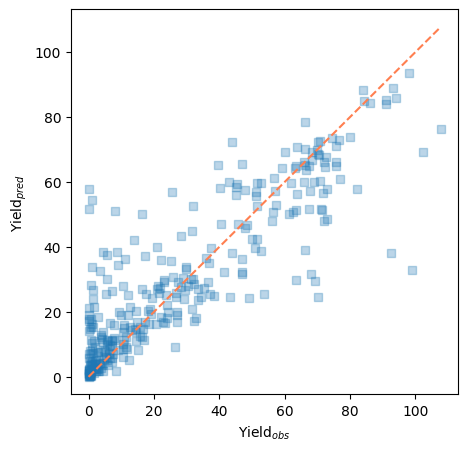

R2: 0.7702, MAE: 8.9020


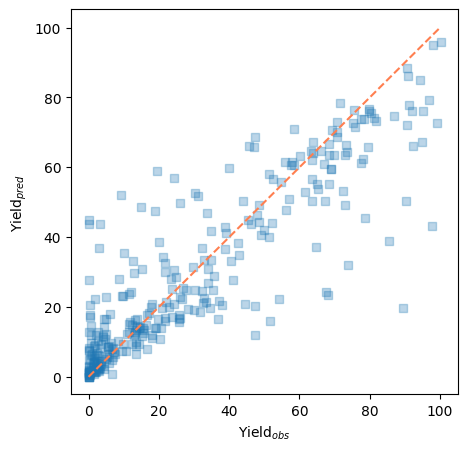

R2: 0.7612, MAE: 9.5669


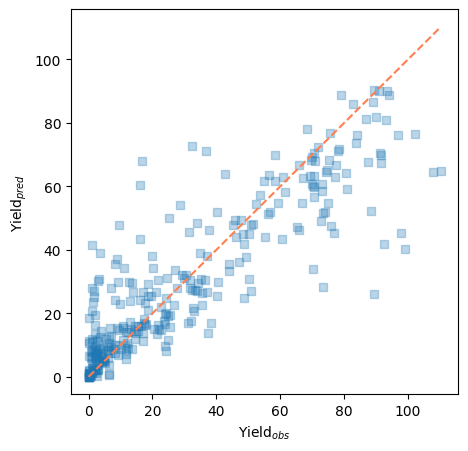

R2: 0.7580, MAE: 9.5661


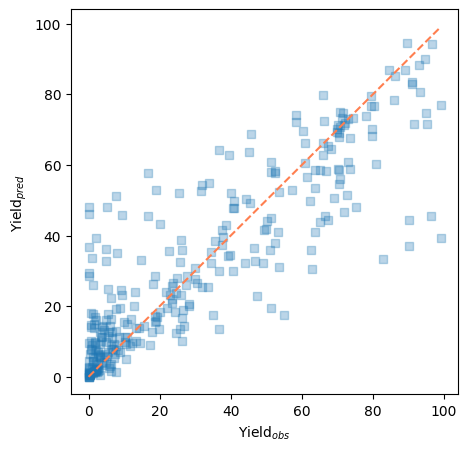

R2: 0.8042, MAE: 8.3526


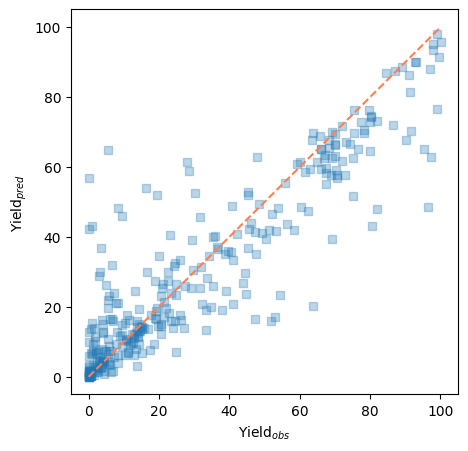

R2: 0.7694, MAE: 9.0465


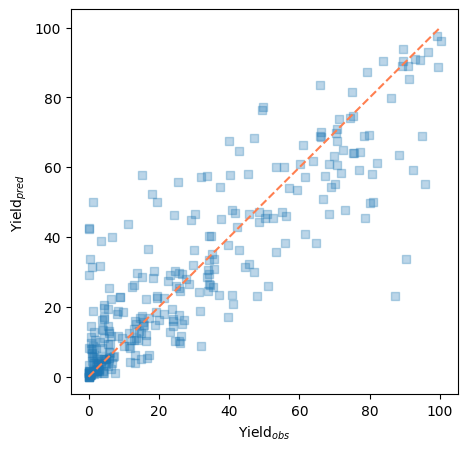

R2: 0.7926, MAE: 8.9150


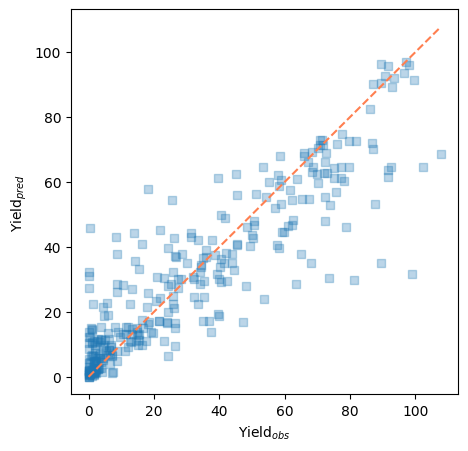

R2: 0.7320, MAE: 9.8149


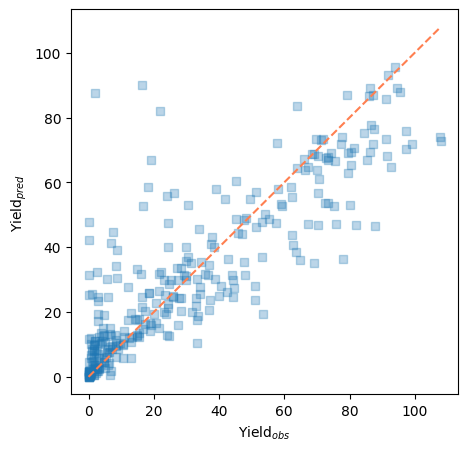

R2: 0.6824, MAE: 9.8401


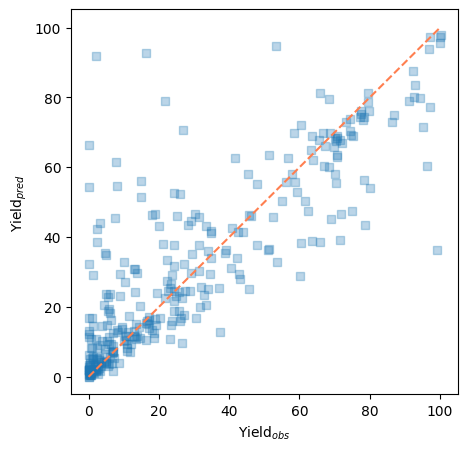

R2: 0.7681, MAE: 9.0840


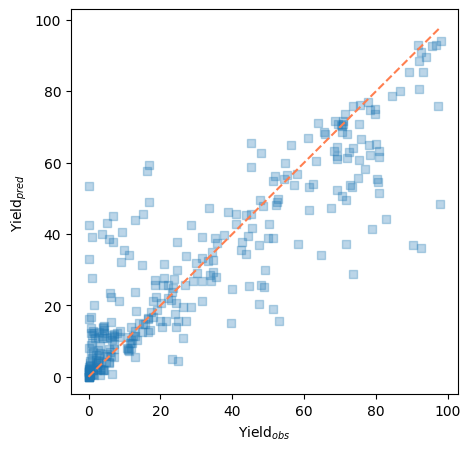

In [24]:
for trial in range(10):
    print(f"R2: {r2_score(all_test_y[trial],all_test_p[trial]):.4f}, MAE: {mean_absolute_error(all_test_y[trial],all_test_p[trial]):.4f}")
    plt.figure(figsize=(5,5))
    plt.scatter(all_test_y[trial],all_test_p[trial],alpha=0.3,marker="s")
    plt.plot([min(all_test_y[trial]),max(all_test_y[trial])],[min(all_test_y[trial]),max(all_test_y[trial])],"--",color="coral")
    plt.xlabel("Yield$_{obs}$")
    plt.ylabel("Yield$_{pred}$")
    plt.show()
    

#### 通用配体推荐

In [25]:
tgt_lig_smi = "c1ccc(-c2nn(-c3ccccc3)c(-c3ccccc3)c2-n2nccc2P(C2CCCCC2)C2CCCCC2)cc1"
lig_smi_yield_map = {}
for lig_smi, yield_ in zip(lig_smi_lst,label):
    if not lig_smi in lig_smi_yield_map:
        lig_smi_yield_map[lig_smi] = [yield_]
    else:
        lig_smi_yield_map[lig_smi].append(yield_)
lig_smi_ave_yield_lst = sorted([[smi,np.mean(lig_smi_yield_map[smi])] for smi in lig_smi_yield_map],key=lambda x: x[1])

In [26]:
len(lig_smi_ave_yield_lst),lig_smi_ave_yield_lst[-1]

(24,
 ['c1ccc(-c2nn(-c3ccccc3)c(-c3ccccc3)c2-n2nccc2P(C2CCCCC2)C2CCCCC2)cc1',
  np.float64(46.18296875)])

In [27]:
batch_size = 2
leave_best_topk = 0
recommend_time = 4
test_time = 100


all_cur_best_lst = []
all_match_best_lig_lst = []
for i in range(test_time):

    cur_best_lst = []
    exp_times = []
    match_best_lig_lst = []
    cur_score,cur_cat,pool_cat = random_init(lig_smi_ave_yield_lst,leave_best_topk=leave_best_topk,batch_size=batch_size,rand_seed=i)
    cur_best_lst.append(max(cur_score))
    exp_times.append(len(cur_score))
    if tgt_lig_smi in [item[0] for item in cur_cat]:
        match_best_lig_lst.append(1)
    else:
        match_best_lig_lst.append(0)

    for _ in range(recommend_time):
        cur_score,cur_cat,pool_cat = recommend_by_random(cur_score,cur_cat,pool_cat,batch_size=batch_size)
        cur_best_lst.append(max(cur_score))
        exp_times.append(len(cur_score))
        if tgt_lig_smi in [item[0] for item in cur_cat]:
            match_best_lig_lst.append(1)
        else:
            match_best_lig_lst.append(0)

    all_cur_best_lst.append(cur_best_lst)
    all_match_best_lig_lst.append(match_best_lig_lst)
rand_ave_cur_best_arr = np.array(all_cur_best_lst).mean(0)
rand_ave_cur_match_best_arr = np.array(all_match_best_lig_lst).mean(0)



best 0 catalyst ddG: [np.float64(4.95109375), np.float64(12.698125000000001), np.float64(14.106875), np.float64(17.80125), np.float64(19.28515625), np.float64(20.73390625), np.float64(22.062968750000003), np.float64(24.30078125), np.float64(27.90203125), np.float64(30.79328125), np.float64(32.190625), np.float64(32.35546875), np.float64(32.57124999999999), np.float64(33.0546875), np.float64(33.2240625), np.float64(36.7384375), np.float64(37.3846875), np.float64(38.27640625), np.float64(38.343125), np.float64(41.83734375), np.float64(42.950781250000006), np.float64(43.6196875), np.float64(43.93296875), np.float64(46.18296875)]
22, 2
Max score: 32.3555, 2
20, 4
Max score: 32.5712, 4
18, 6
Max score: 38.3431, 6
16, 8
Max score: 46.1830, 8
14, 10
Max score: 46.1830, 10
best 0 catalyst ddG: [np.float64(4.95109375), np.float64(12.698125000000001), np.float64(14.106875), np.float64(17.80125), np.float64(19.28515625), np.float64(20.73390625), np.float64(22.062968750000003), np.float64(24.30078

Text(0, 0.5, 'Maximum yield')

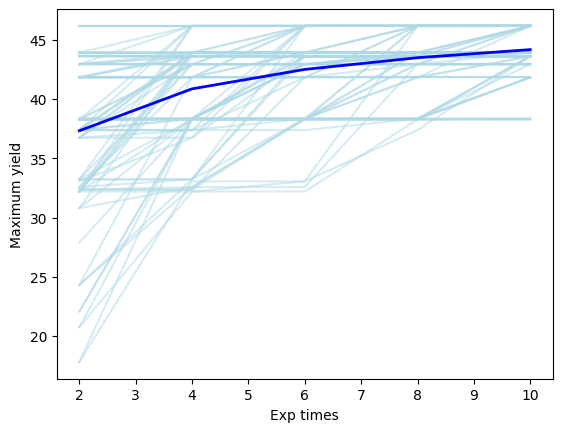

In [28]:
for cur_best_lst in all_cur_best_lst:
    plt.plot(exp_times,cur_best_lst,c='lightblue',alpha=0.5)
    
plt.plot(exp_times,rand_ave_cur_best_arr,c='blue',linewidth=2)
plt.xlabel('Exp times')
plt.ylabel('Maximum yield')

Text(0, 0.5, 'Match best ratio')

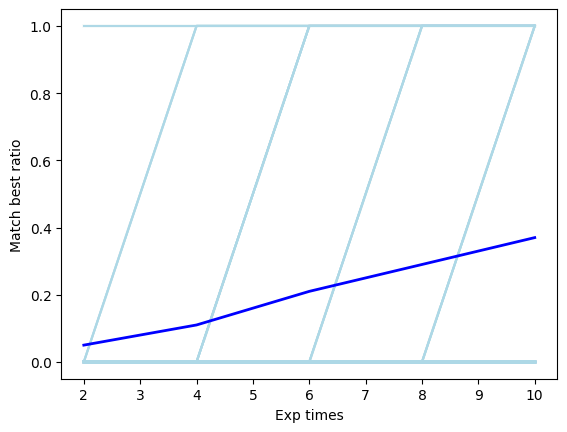

In [29]:
for match_best_lig_lst in all_match_best_lig_lst:
    plt.plot(exp_times,match_best_lig_lst,c='lightblue',alpha=0.5)
    
plt.plot(exp_times,rand_ave_cur_match_best_arr,c='blue',linewidth=2)
plt.xlabel('Exp times')
plt.ylabel('Match best ratio')

In [30]:
all_cur_best_lst = []
all_match_best_lig_lst = []
for i in range(test_time):

    cur_best_lst = []
    exp_times = []
    match_best_lig_lst = []
    cur_score,cur_cat,pool_cat = random_init(lig_smi_ave_yield_lst,leave_best_topk=leave_best_topk,batch_size=batch_size,rand_seed=i)
    cur_best_lst.append(max(cur_score))
    exp_times.append(len(cur_score))
    
    if tgt_lig_smi in [item[0] for item in cur_cat]:
        match_best_lig_lst.append(1)
    else:
        match_best_lig_lst.append(0)
    
    for _ in range(recommend_time):
        cur_score,cur_cat,pool_cat = cur_score,cur_cat,pool_cat = recommend_by_dist(catemb_calc,cur_score,cur_cat,pool_cat,batch_size=batch_size,best_n=1)
        cur_best_lst.append(max(cur_score))
        exp_times.append(len(cur_score))
        
        if tgt_lig_smi in [item[0] for item in cur_cat]:
            match_best_lig_lst.append(1)
        else:
            match_best_lig_lst.append(0)
    all_cur_best_lst.append(cur_best_lst)
    all_match_best_lig_lst.append(match_best_lig_lst)
dist_ave_cur_best_arr = np.array(all_cur_best_lst).mean(0)
dist_ave_cur_match_best_arr = np.array(all_match_best_lig_lst).mean(0)


best 0 catalyst ddG: [np.float64(4.95109375), np.float64(12.698125000000001), np.float64(14.106875), np.float64(17.80125), np.float64(19.28515625), np.float64(20.73390625), np.float64(22.062968750000003), np.float64(24.30078125), np.float64(27.90203125), np.float64(30.79328125), np.float64(32.190625), np.float64(32.35546875), np.float64(32.57124999999999), np.float64(33.0546875), np.float64(33.2240625), np.float64(36.7384375), np.float64(37.3846875), np.float64(38.27640625), np.float64(38.343125), np.float64(41.83734375), np.float64(42.950781250000006), np.float64(43.6196875), np.float64(43.93296875), np.float64(46.18296875)]
22, 2
Max score: 32.3555, 2
20, 4
Max score: 32.3555, 4
18, 6
Max score: 38.3431, 6
16, 8
Max score: 38.3431, 8
14, 10
Max score: 38.3431, 10
best 0 catalyst ddG: [np.float64(4.95109375), np.float64(12.698125000000001), np.float64(14.106875), np.float64(17.80125), np.float64(19.28515625), np.float64(20.73390625), np.float64(22.062968750000003), np.float64(24.30078

Text(0, 0.5, 'Maximum yield')

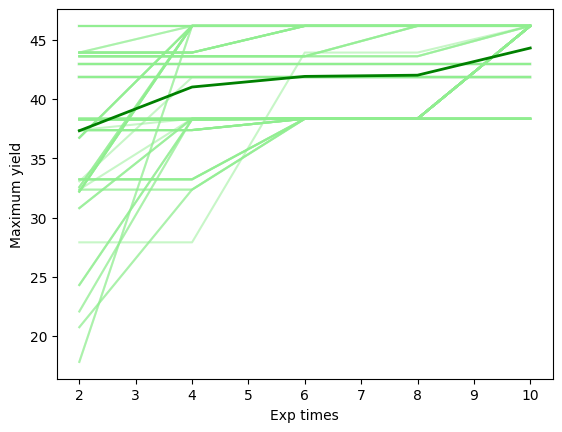

In [31]:
for cur_best_lst in all_cur_best_lst:
    plt.plot(exp_times,cur_best_lst,c='lightgreen',alpha=0.5)
plt.plot(exp_times,dist_ave_cur_best_arr,c='green',linewidth=2)
plt.xlabel('Exp times')
plt.ylabel('Maximum yield')

Text(0, 0.5, 'Match best ratio')

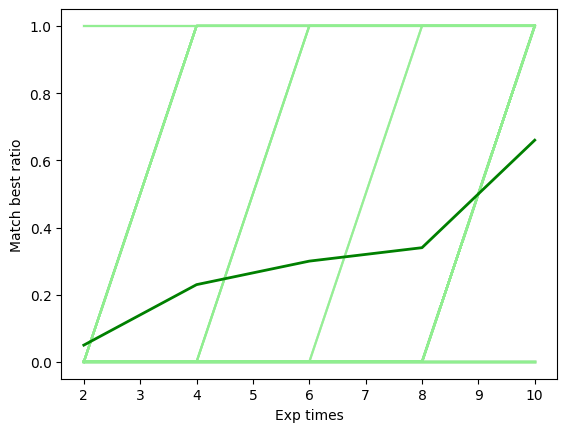

In [32]:
for match_best_lig_lst in all_match_best_lig_lst:
    plt.plot(exp_times,match_best_lig_lst,c='lightgreen',alpha=0.5)
    
plt.plot(exp_times,dist_ave_cur_match_best_arr,c='green',linewidth=2)
plt.xlabel('Exp times')
plt.ylabel('Match best ratio')

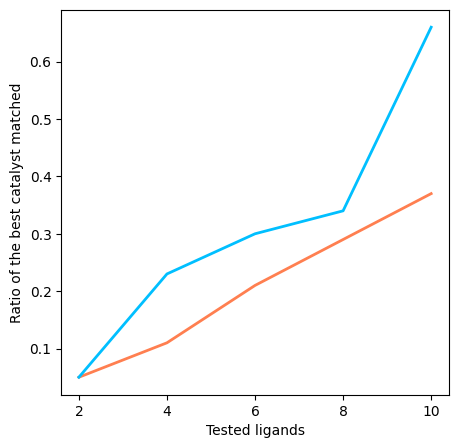

In [33]:
plt.figure(figsize=(5,5))
plt.plot(exp_times,rand_ave_cur_match_best_arr,c='coral',linewidth=2)
plt.plot(exp_times,dist_ave_cur_match_best_arr,c='deepskyblue',linewidth=2)
plt.xlabel('Tested ligands')
plt.ylabel('Ratio of the best catalyst matched')
plt.xticks([2,4,6,8,10],['2','4','6','8','10'])
print()
#plt.xticks([0,2,4,6,8,10],['0','2','4','6','8','10'])
#plt.yticks([0.1,0.15,0.2,0.25,0.3,0.35,0.4],["0.10","0.15","0.20","0.25","0.30","0.35","0.40"])

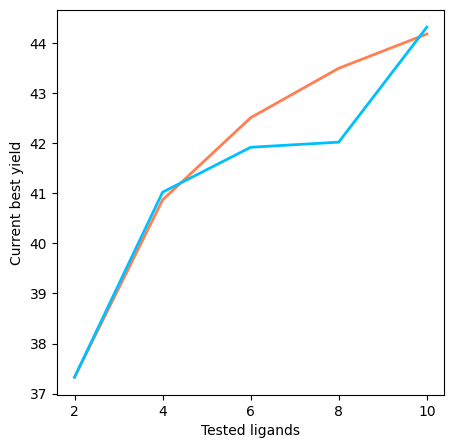

In [34]:
plt.figure(figsize=(5,5))
plt.plot(exp_times,rand_ave_cur_best_arr,c='coral',linewidth=2)
plt.plot(exp_times,dist_ave_cur_best_arr,c='deepskyblue',linewidth=2)
plt.xlabel('Tested ligands')
plt.ylabel('Current best yield')
plt.xticks([2,4,6,8,10],['2','4','6','8','10'])
print()
#plt.xticks([0,2,4,6,8,10],['0','2','4','6','8','10'])
#plt.yticks([0.1,0.15,0.2,0.25,0.3,0.35,0.4],["0.10","0.15","0.20","0.25","0.30","0.35","0.40"])

### Denmark数据集

In [62]:
rxn_data = pd.read_csv("../dataset/rxn_data/denmark/NS_acetal_dataset_with_pdt.csv")
rxn_data

,Unnamed: 0,Imine,Thiol,Catalyst,ΔΔG,Product
0,0,O=C(/N=C/c1ccccc1)c1ccccc1,Sc1ccccc1,O=P1(O)Oc2c(-c3ccccc3)cc3ccccc3c2-c2c(c(-c3ccc...,1.179891,O=C(NC(Sc1ccccc1)c1ccccc1)c1ccccc1
1,1,O=C(/N=C/c1ccccc1)c1ccccc1,CCS,O=P1(O)Oc2c(-c3ccccc3)cc3ccccc3c2-c2c(c(-c3ccc...,0.501759,CCSC(NC(=O)c1ccccc1)c1ccccc1
2,2,O=C(/N=C/c1ccccc1)c1ccccc1,SC1CCCCC1,O=P1(O)Oc2c(-c3ccccc3)cc3ccccc3c2-c2c(c(-c3ccc...,0.650584,O=C(NC(SC1CCCCC1)c1ccccc1)c1ccccc1
3,3,O=C(/N=C/c1ccccc1)c1ccccc1,COc1ccc(S)cc1,O=P1(O)Oc2c(-c3ccccc3)cc3ccccc3c2-c2c(c(-c3ccc...,1.238109,COc1ccc(SC(NC(=O)c2ccccc2)c2ccccc2)cc1
4,4,O=C(/N=C/c1ccc(C(F)(F)F)cc1)c1ccccc1,Sc1ccccc1,O=P1(O)Oc2c(-c3ccccc3)cc3ccccc3c2-c2c(c(-c3ccc...,1.179891,O=C(NC(Sc1ccccc1)c1ccc(C(F)(F)F)cc1)c1ccccc1
...,...,...,...,...,...,...
1070,1070,O=C(/N=C/c1ccccc1)c1ccccc1,Sc1ccccc1,O=P1(O)Oc2c(-c3cc(C(F)(F)F)cc(C(F)(F)F)c3)cc3c...,1.531803,O=C(NC(Sc1ccccc1)c1ccccc1)c1ccccc1
1071,1071,O=C(/N=C/c1ccccc1)c1ccccc1,Cc1ccccc1S,O=P1(O)Oc2c(-c3cc(C(F)(F)F)cc(C(F)(F)F)c3)cc3c...,1.531803,Cc1ccccc1SC(NC(=O)c1ccccc1)c1ccccc1
1072,1072,O=C(/N=C/c1ccc(C(F)(F)F)cc1)c1ccccc1,Cc1ccccc1S,O=P1(O)Oc2c(-c3cc(C(F)(F)F)cc(C(F)(F)F)c3)cc3c...,1.370104,Cc1ccccc1SC(NC(=O)c1ccccc1)c1ccc(C(F)(F)F)cc1
1073,1073,O=C(/N=C/c1cccc2ccccc12)c1ccccc1,Sc1ccccc1,O=P1(O)Oc2c(-c3cc(C(F)(F)F)cc(C(F)(F)F)c3)cc3c...,1.301167,O=C(NC(Sc1ccccc1)c1cccc2ccccc12)c1ccccc1


In [63]:
imine_lst = rxn_data['Imine'].to_list()
thiol_lst = rxn_data['Thiol'].to_list()
cat_lst = rxn_data['Catalyst'].to_list()
pdt_lst = rxn_data['Product'].to_list()
label = rxn_data['ΔΔG'].to_numpy()

In [64]:
cat_label_map = {}
for cat,l in zip(cat_lst,label):
    if cat not in cat_label_map:
        cat_label_map[cat] = []
    cat_label_map[cat].append(l)
cat_label_lst = sorted([[cat,np.mean(l)] for cat,l in cat_label_map.items()],key=lambda x:x[1])

In [65]:
cat_label_lst[-1]

['O=P1(O)Oc2c(-c3c(C4CCCCC4)cc(C4CCCCC4)cc3C3CCCCC3)cc3ccccc3c2-c2c(c(-c3c(C4CCCCC4)cc(C4CCCCC4)cc3C3CCCCC3)cc3ccccc23)O1',
 np.float64(2.3947055244)]

In [66]:
rxn_lst = [f"{imine}.{thiol}>>{pdt}" for imine,thiol,pdt in zip(imine_lst,thiol_lst,pdt_lst)]
rxn_emb_arr = rxnemb_calc.gen_rxn_emb(rxn_lst).numpy()
cat_emb_arr = catemb_calc.gen_desc(cat_lst)

Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 1075/1075 [00:01<00:00, 625.36it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 1075/1075 [00:01<00:00, 813.53it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 9/9 [00:03<00:00,  2.51it/s]


In [40]:
np.save("./gen_desc/denmark_cat_emb.npy",{"desc":cat_emb_arr.tolist(),"smi":cat_lst})
np.savetxt("./gen_desc/denmark_cat_emb.txt",cat_emb_arr)
np.savetxt("./gen_desc/denmark_cat_emb_smi.txt",cat_lst,fmt="%s")

In [41]:
full_emb_arr = np.concatenate([rxn_emb_arr,cat_emb_arr],axis=1)

#### 随机划分

In [42]:
r2_ave = []
mae_ave = []
all_test_y = []
all_test_p = []
#model = deepcopy(model2)
model = ExtraTreesRegressor(n_estimators=500,random_state=random_seed,n_jobs=-1)
for seed in range(10):
    train_x,test_x,train_y,test_y = train_test_split(full_emb_arr,label,test_size=475/1075,random_state=seed)
    model.fit(train_x,train_y)
    test_p = model.predict(test_x)
    all_test_y.append(test_y)
    all_test_p.append(test_p)
    r2 = r2_score(test_y,test_p)
    mae = mean_absolute_error(test_y,test_p)
    print(f"seed: {seed}, r2: {r2:.4f}, mae: {mae:.4f}")

    r2_ave.append(r2)
    mae_ave.append(mae)
r2_ave = np.mean(r2_ave)
mae_ave = np.mean(mae_ave)
print(f"r2_ave: {r2_ave:.4f}, mae_ave: {mae_ave:.4f}")

seed: 0, r2: 0.8863, mae: 0.1539
seed: 1, r2: 0.8930, mae: 0.1500
seed: 2, r2: 0.8962, mae: 0.1495
seed: 3, r2: 0.8955, mae: 0.1472
seed: 4, r2: 0.9018, mae: 0.1483
seed: 5, r2: 0.8980, mae: 0.1551
seed: 6, r2: 0.8853, mae: 0.1536
seed: 7, r2: 0.8980, mae: 0.1532
seed: 8, r2: 0.9036, mae: 0.1477
seed: 9, r2: 0.8911, mae: 0.1614
r2_ave: 0.8949, mae_ave: 0.1520


R2: 0.8863, MAE: 0.1539


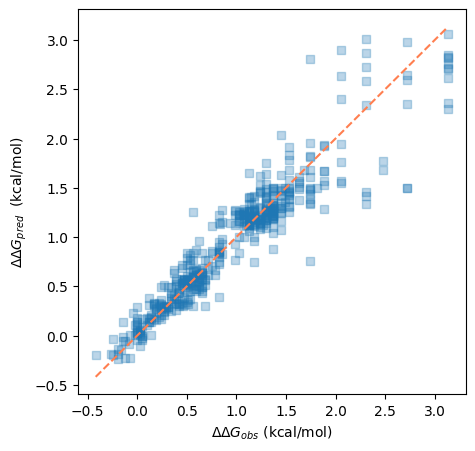

R2: 0.8930, MAE: 0.1500


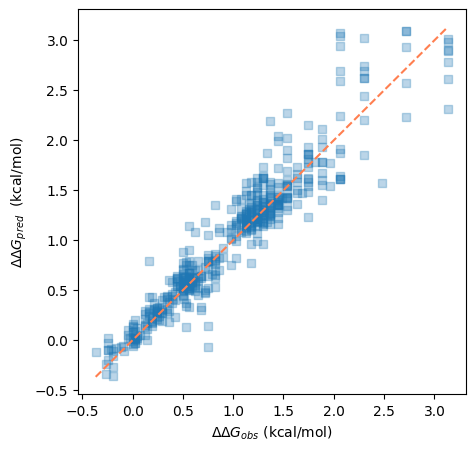

R2: 0.8962, MAE: 0.1495


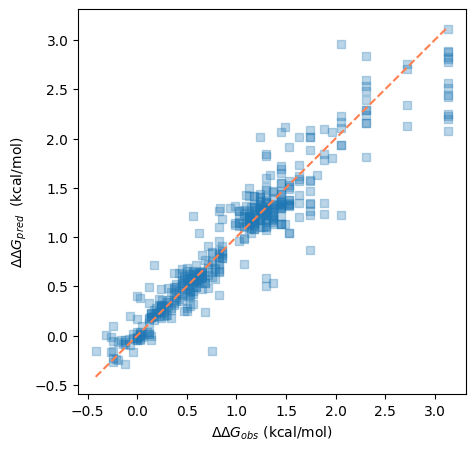

R2: 0.8955, MAE: 0.1472


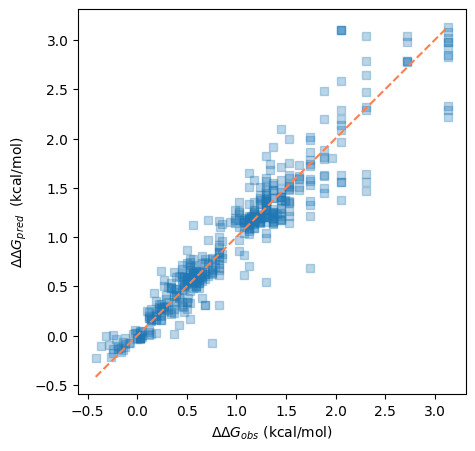

R2: 0.9018, MAE: 0.1483


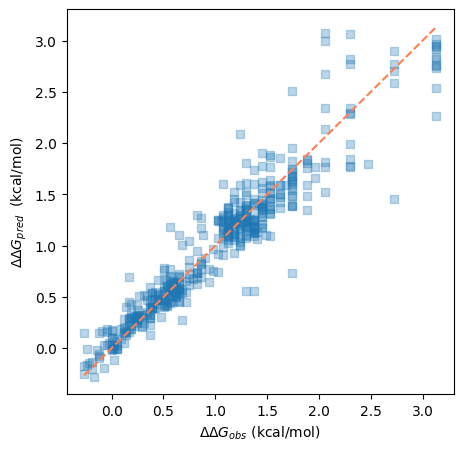

R2: 0.8980, MAE: 0.1551


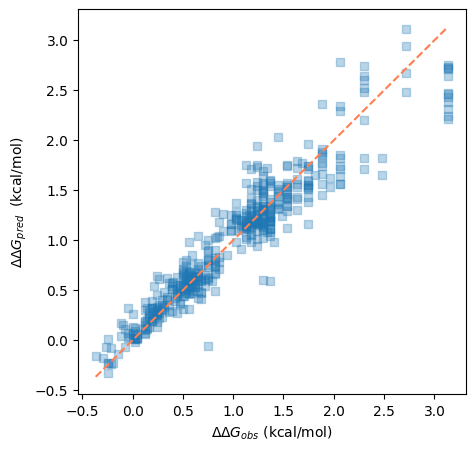

R2: 0.8853, MAE: 0.1536


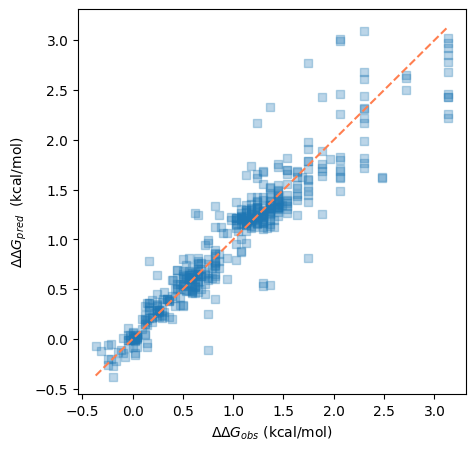

R2: 0.8980, MAE: 0.1532


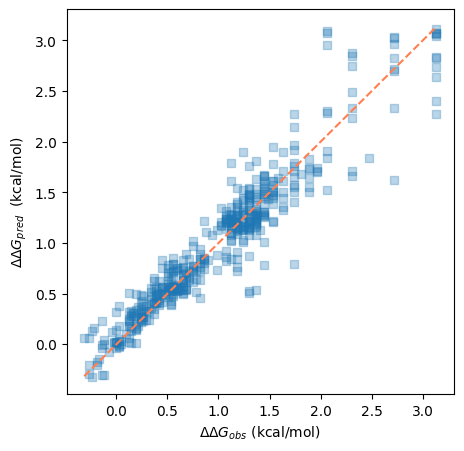

R2: 0.9036, MAE: 0.1477


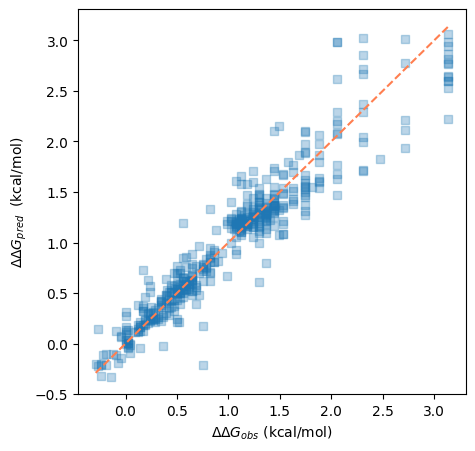

R2: 0.8911, MAE: 0.1614


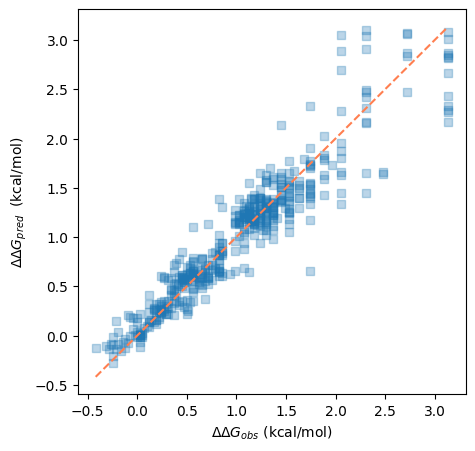

In [43]:
for trial in range(10):
    print(f"R2: {r2_score(all_test_y[trial],all_test_p[trial]):.4f}, MAE: {mean_absolute_error(all_test_y[trial],all_test_p[trial]):.4f}")
    plt.figure(figsize=(5,5))
    plt.scatter(all_test_y[trial],all_test_p[trial],alpha=0.3,marker="s")
    plt.plot([min(all_test_y[trial]),max(all_test_y[trial])],[min(all_test_y[trial]),max(all_test_y[trial])],"--",color="coral")
    plt.xlabel("$\Delta$$\Delta$$G$$_{obs}$ (kcal/mol)")
    plt.ylabel("$\Delta$$\Delta$$G$$_{pred}$  (kcal/mol)")
    plt.show()
    

#### 样本外

In [44]:
oos_imine = ['O=C(/N=C/c1ccc(Cl)cc1Cl)c1ccccc1']
oos_thiol = ['Cc1ccccc1S']
oos_cat = ['O=P1(O)Oc2c(-c3c(C4CCCCC4)cc(C4CCCCC4)cc3C3CCCCC3)cc3ccccc3c2-c2c(c(-c3c(C4CCCCC4)cc(C4CCCCC4)cc3C3CCCCC3)cc3ccccc23)O1',
 'CC(C)c1cc(C(C)C)c(-c2cc3ccccc3c3c2OP(=O)(O)Oc2c(-c4c(C(C)C)cc(C(C)C)cc4C(C)C)cc4ccccc4c2-3)c(C(C)C)c1',
 'COc1cccc(OC)c1-c1cc2ccccc2c2c1OP(=O)(O)Oc1c(-c3c(OC)cccc3OC)cc3ccccc3c1-2',
 'Cc1cc(C)c(-c2cc3ccccc3c3c2OP(=O)(O)Oc2c(-c4c(C)cc(C)cc4C)cc4ccccc4c2-3)c(C)c1',
 'O=P1(O)Oc2c(-c3c4ccccc4cc4ccccc34)cc3ccccc3c2-c2c(c(-c3c4ccccc4cc4ccccc34)cc3ccccc23)O1',
 'O=P1(O)Oc2c(-c3ccc4ccc5cccc6ccc3c4c56)cc3ccccc3c2-c2c(c(-c3ccc4ccc5cccc6ccc3c4c56)cc3ccccc23)O1', 
 'O=P1(O)Oc2c(-c3ccccc3OC(F)(F)F)cc3ccccc3c2-c2c(c(-c3ccccc3OC(F)(F)F)cc3ccccc23)O1',
 'CC(C)(C)c1cc(-c2cc3ccccc3c3c2OP(=O)(O)Oc2c(-c4cc(C(C)(C)C)cc(C(C)(C)C)c4)cc4ccccc4c2-3)cc(C(C)(C)C)c1',
 'CC(C)(C)c1cc(-c2cc3c(c4c2OP(=O)(O)Oc2c(-c5cc(C(C)(C)C)cc(C(C)(C)C)c5)cc5c(c2-4)CCCC5)CCCC3)cc(C(C)(C)C)c1',
 'Cc1ccc(-c2cc3ccccc3c3c2OP(=O)(O)Oc2c(-c4ccc(C)cc4)cc4ccccc4c2-3)cc1',
 'CC(C)(C)c1ccc(-c2cc3ccccc3c3c2OP(=O)(O)Oc2c(-c4ccc(C(C)(C)C)cc4)cc4ccccc4c2-3)cc1',
 'O=P1(O)Oc2c(-c3ccc(-c4ccc5ccccc5c4)cc3)cc3ccccc3c2-c2c(c(-c3ccc(-c4ccc5ccccc5c4)cc3)cc3ccccc23)O1',
 'COc1ccc(-c2cc3ccccc3c3c2OP(=O)(O)Oc2c(-c4ccc(OC)cc4)cc4ccccc4c2-3)cc1',
 'COCc1cccc(-c2cc3c(c4c2OP(=O)(O)Oc2c(-c5cccc(COC)c5)cc5c(c2-4)CCCC5)CCCC3)c1',
 'O=P1(O)Oc2c(-c3ccccc3)cc3ccccc3c2-c2c(c(-c3ccccc3)cc3ccccc23)O1',
 'C[Si](c1ccccc1)(c1ccccc1)c1cc2ccccc2c2c1OP(=O)(O)Oc1c([Si](C)(c3ccccc3)c3ccccc3)cc3ccccc3c1-2',
 'O=P1(O)Oc2c(Br)cc3c(c2-c2c4c(cc(Br)c2O1)CCCC4)CCCC3',
 'O=P1(O)Oc2c([Si](c3ccccc3)(c3ccccc3)c3ccccc3)cc3ccccc3c2-c2c(c([Si](c3ccccc3)(c3ccccc3)c3ccccc3)cc3ccccc23)O1',
 'O=P1(O)Oc2c(Cc3ccc(C(F)(F)F)cc3C(F)(F)F)cc3ccccc3c2-c2c(c(Cc3ccc(C(F)(F)F)cc3C(F)(F)F)cc3ccccc23)O1']
train_data_idx_lst = []
sub_test_data_idx_lst = []
cat_test_data_idx_lst = []
sub_cat_test_data_idx_lst = []
for i in range(len(imine_lst)):
    imine_smi = imine_lst[i]
    thiol_smi = thiol_lst[i]
    cat_smi = cat_lst[i]
    if (imine_smi in oos_imine or thiol_smi in oos_thiol) and not (cat_smi in oos_cat):
        sub_test_data_idx_lst.append(i)
    elif (cat_smi in oos_cat) and not (imine_smi in oos_imine or thiol_smi in oos_thiol):
        cat_test_data_idx_lst.append(i)
    elif (imine_smi in oos_imine or thiol_smi in oos_thiol) and (cat_smi in oos_cat):
        sub_cat_test_data_idx_lst.append(i)
    else:
        train_data_idx_lst.append(i)
len(train_data_idx_lst),len(sub_test_data_idx_lst),len(cat_test_data_idx_lst),len(sub_cat_test_data_idx_lst)

(384, 216, 304, 171)

In [45]:
train_x = full_emb_arr[train_data_idx_lst]
train_y = label[train_data_idx_lst]
sub_test_x = full_emb_arr[sub_test_data_idx_lst]
sub_test_y = label[sub_test_data_idx_lst]
cat_test_x = full_emb_arr[cat_test_data_idx_lst]
cat_test_y = label[cat_test_data_idx_lst]
sub_cat_test_x = full_emb_arr[sub_cat_test_data_idx_lst]
sub_cat_test_y = label[sub_cat_test_data_idx_lst]
model1.fit(train_x,train_y)
sub_test_p = model1.predict(sub_test_x)
cat_test_p = model1.predict(cat_test_x)
sub_cat_test_p = model1.predict(sub_cat_test_x)
r2_sub_test = r2_score(sub_test_y,sub_test_p)
r2_cat_test = r2_score(cat_test_y,cat_test_p)
r2_sub_cat_test = r2_score(sub_cat_test_y,sub_cat_test_p)
mae_sub_test = mean_absolute_error(sub_test_y,sub_test_p)
mae_cat_test = mean_absolute_error(cat_test_y,cat_test_p)
mae_sub_cat_test = mean_absolute_error(sub_cat_test_y,sub_cat_test_p)
#print(f"r2_sub_test: {r2_sub_test:.4f}, r2_cat_test: {r2_cat_test:.4f}, r2_sub_cat_test: {r2_sub_cat_test:.4f}")
print(f"mae_sub_test: {mae_sub_test:.4f}, mae_cat_test: {mae_cat_test:.4f}, mae_sub_cat_test: {mae_sub_cat_test:.4f}")

NameError: name 'model1' is not defined

In [46]:
train_x = full_emb_arr[train_data_idx_lst]
train_y = label[train_data_idx_lst]
sub_test_x = full_emb_arr[sub_test_data_idx_lst]
sub_test_y = label[sub_test_data_idx_lst]
cat_test_x = full_emb_arr[cat_test_data_idx_lst]
cat_test_y = label[cat_test_data_idx_lst]
sub_cat_test_x = full_emb_arr[sub_cat_test_data_idx_lst]
sub_cat_test_y = label[sub_cat_test_data_idx_lst]
model2.fit(train_x,train_y)
sub_test_p = model2.predict(sub_test_x)
cat_test_p = model2.predict(cat_test_x)
sub_cat_test_p = model2.predict(sub_cat_test_x)
r2_sub_test = r2_score(sub_test_y,sub_test_p)
r2_cat_test = r2_score(cat_test_y,cat_test_p)
r2_sub_cat_test = r2_score(sub_cat_test_y,sub_cat_test_p)
mae_sub_test = mean_absolute_error(sub_test_y,sub_test_p)
mae_cat_test = mean_absolute_error(cat_test_y,cat_test_p)
mae_sub_cat_test = mean_absolute_error(sub_cat_test_y,sub_cat_test_p)
#print(f"r2_sub_test: {r2_sub_test:.4f}, r2_cat_test: {r2_cat_test:.4f}, r2_sub_cat_test: {r2_sub_cat_test:.4f}")
print(f"mae_sub_test: {mae_sub_test:.4f}, mae_cat_test: {mae_cat_test:.4f}, mae_sub_cat_test: {mae_sub_cat_test:.4f}")

NameError: name 'model2' is not defined

In [52]:
train_x = full_emb_arr[train_data_idx_lst]
train_y = label[train_data_idx_lst]
sub_test_x = full_emb_arr[sub_test_data_idx_lst]
sub_test_y = label[sub_test_data_idx_lst]
cat_test_x = full_emb_arr[cat_test_data_idx_lst]
cat_test_y = label[cat_test_data_idx_lst]
sub_cat_test_x = full_emb_arr[sub_cat_test_data_idx_lst]
sub_cat_test_y = label[sub_cat_test_data_idx_lst]
model3.fit(train_x,train_y)
sub_test_p = model3.predict(sub_test_x)
cat_test_p = model3.predict(cat_test_x)
sub_cat_test_p = model3.predict(sub_cat_test_x)
r2_sub_test = r2_score(sub_test_y,sub_test_p)
r2_cat_test = r2_score(cat_test_y,cat_test_p)
r2_sub_cat_test = r2_score(sub_cat_test_y,sub_cat_test_p)
mae_sub_test = mean_absolute_error(sub_test_y,sub_test_p)
mae_cat_test = mean_absolute_error(cat_test_y,cat_test_p)
mae_sub_cat_test = mean_absolute_error(sub_cat_test_y,sub_cat_test_p)
#print(f"r2_sub_test: {r2_sub_test:.4f}, r2_cat_test: {r2_cat_test:.4f}, r2_sub_cat_test: {r2_sub_cat_test:.4f}")
print(f"mae_sub_test: {mae_sub_test:.4f}, mae_cat_test: {mae_cat_test:.4f}, mae_sub_cat_test: {mae_sub_cat_test:.4f}")

mae_sub_test: 0.4938, mae_cat_test: 0.4262, mae_sub_cat_test: 0.7320


#### 推综合高选择性配体

In [47]:
len(cat_label_lst)

43

In [48]:
sorted(cat_label_lst, key=lambda x: x[1], reverse=True)

[['O=P1(O)Oc2c(-c3c(C4CCCCC4)cc(C4CCCCC4)cc3C3CCCCC3)cc3ccccc3c2-c2c(c(-c3c(C4CCCCC4)cc(C4CCCCC4)cc3C3CCCCC3)cc3ccccc23)O1',
  np.float64(2.3947055244)],
 ['CC(C)c1cc(-c2ccc(C(C)(C)C)cc2)cc(C(C)C)c1-c1cc2ccccc2c2c1OP(=O)(O)Oc1c(-c3c(C(C)C)cc(-c4ccc(C(C)(C)C)cc4)cc3C(C)C)cc3ccccc3c1-2',
  np.float64(2.23576684724)],
 ['CC(C)c1cc(C(C)C)c(-c2cc3ccccc3c3c2OP(=O)(O)Oc2c(-c4c(C(C)C)cc(C(C)C)cc4C(C)C)cc4ccccc4c2-3)c(C(C)C)c1',
  np.float64(2.19275207928)],
 ['O=P1(O)Oc2c(-c3c4ccccc4c(-c4ccc5ccccc5c4)c4ccccc34)cc3ccccc3c2-c2c(c(-c3c4ccccc4c(-c4ccc5ccccc5c4)c4ccccc34)cc3ccccc23)O1',
  np.float64(1.95282315716)],
 ['COc1cccc(OC)c1-c1cc2ccccc2c2c1OP(=O)(O)Oc1c(-c3c(OC)cccc3OC)cc3ccccc3c1-2',
  np.float64(1.5895135452399998)],
 ['O=P1(O)Oc2c(-c3c(Cl)cc(Cl)cc3Cl)cc3c(c2-c2c4c(cc(-c5c(Cl)cc(Cl)cc5Cl)c2O1)CCCC4)CCCC3',
  np.float64(1.56640721504)],
 ['Cc1cc(C)c(-c2cc3ccccc3c3c2OP(=O)(O)Oc2c(-c4c(C)cc(C)cc4C)cc4ccccc4c2-3)c(C)c1',
  np.float64(1.5240829211599998)],
 ['O=P1(O)Oc2c(-c3c4ccccc4cc4ccccc34

In [49]:
tgt_cat_smi = 'O=P1(O)Oc2c(-c3c(C4CCCCC4)cc(C4CCCCC4)cc3C3CCCCC3)cc3ccccc3c2-c2c(c(-c3c(C4CCCCC4)cc(C4CCCCC4)cc3C3CCCCC3)cc3ccccc23)O1'
batch_size = 2
leave_best_topk = 0
recommend_time = 9
test_time = 100


all_cur_best_lst = []
all_match_best_lig_lst = []
cur_max_score_lst = []
for i in range(test_time):

    cur_best_lst = []
    exp_times = []
    match_best_lig_lst = []
    cur_score,cur_cat,pool_cat = random_init(cat_label_lst,leave_best_topk=leave_best_topk,batch_size=batch_size,rand_seed=i)
    if len(cur_score) > 0:
        max_score = max(cur_score)
    else:
        max_score = 0
    cur_best_lst.append(max_score)
    exp_times.append(len(cur_score))
    if tgt_cat_smi in [item[0] for item in cur_cat]:
        match_best_lig_lst.append(1)
    else:
        match_best_lig_lst.append(0)

    for _ in range(recommend_time):
        cur_score,cur_cat,pool_cat = recommend_by_random(cur_score,cur_cat,pool_cat,batch_size=batch_size)
        cur_best_lst.append(max(cur_score))
        exp_times.append(len(cur_score))
        if tgt_cat_smi in [item[0] for item in cur_cat]:
            match_best_lig_lst.append(1)
        else:
            match_best_lig_lst.append(0)

    all_cur_best_lst.append(cur_best_lst)
    all_match_best_lig_lst.append(match_best_lig_lst)
rand_ave_cur_best_arr = np.array(all_cur_best_lst).mean(0)
rand_ave_cur_match_best_arr = np.array(all_match_best_lig_lst).mean(0)



best 0 catalyst ddG: [np.float64(0.03711746028), np.float64(0.10016049476), np.float64(0.11951940963999999), np.float64(0.12085957976), np.float64(0.14336383332), np.float64(0.1512067412), np.float64(0.22700402279999998), np.float64(0.23357146856), np.float64(0.24017755047999997), np.float64(0.54519902392), np.float64(0.6235236937599999), np.float64(0.88947511908), np.float64(0.8900880875999999), np.float64(0.8995831816800001), np.float64(0.91206074284), np.float64(0.9261619985199999), np.float64(0.9316345056799998), np.float64(0.93403586644), np.float64(0.94422131788), np.float64(0.9615974247600002), np.float64(0.9640426462399999), np.float64(0.9856560910800001), np.float64(0.99051954524), np.float64(0.9918570946399998), np.float64(1.0095220376), np.float64(1.0177862683999999), np.float64(1.04296387876), np.float64(1.10050943544), np.float64(1.11206407256), np.float64(1.1337612234799999), np.float64(1.18918930644), np.float64(1.20314237828), np.float64(1.26550633744), np.float64(1.296

Text(0, 0.5, 'Maximum $\\Delta$$\\Delta$G')

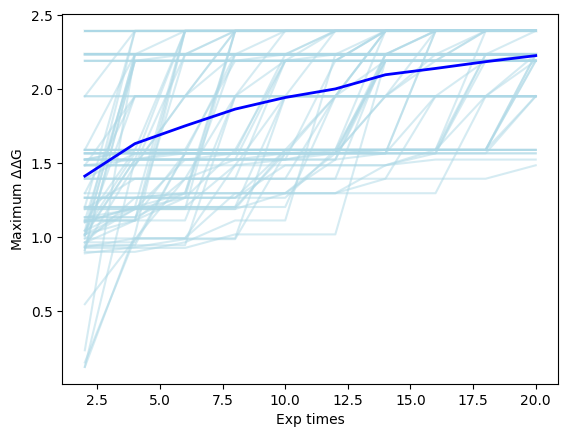

In [50]:
for cur_best_lst in all_cur_best_lst:
    plt.plot(exp_times,cur_best_lst,c='lightblue',alpha=0.5)
    
plt.plot(exp_times,rand_ave_cur_best_arr,c='blue',linewidth=2)
plt.xlabel('Exp times')
plt.ylabel('Maximum $\Delta$$\Delta$G')

In [51]:
cur_best_lst

[np.float64(1.5895135452399998),
 np.float64(1.5895135452399998),
 np.float64(1.5895135452399998),
 np.float64(1.5895135452399998),
 np.float64(1.5895135452399998),
 np.float64(1.5895135452399998),
 np.float64(1.5895135452399998),
 np.float64(1.5895135452399998),
 np.float64(2.23576684724),
 np.float64(2.23576684724)]

Text(0, 0.5, 'Match best ratio')

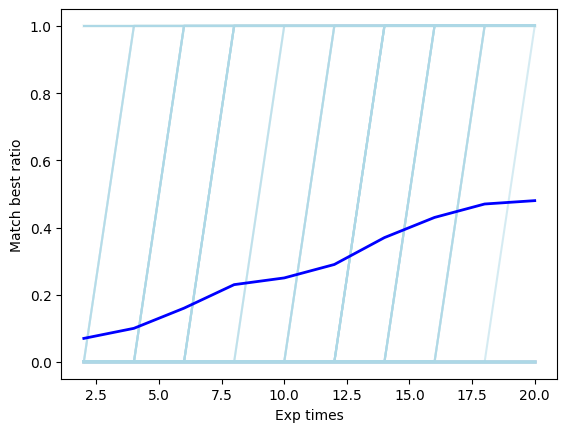

In [52]:
for match_best_lig_lst in all_match_best_lig_lst:
    plt.plot(exp_times,match_best_lig_lst,c='lightblue',alpha=0.5)
    
plt.plot(exp_times,rand_ave_cur_match_best_arr,c='blue',linewidth=2)
# 绘制标准差范围
#plt.fill_between(exp_times, rand_min_cur_match_best_arr, rand_max_cur_match_best_arr, color='blue', alpha=0.2)
plt.xlabel('Exp times')
plt.ylabel('Match best ratio')

In [53]:
all_cur_best_lst = []
all_match_best_lig_lst = []
for i in range(test_time):

    cur_best_lst = []
    exp_times = []
    match_best_lig_lst = []
    cur_score,cur_cat,pool_cat = random_init(cat_label_lst,leave_best_topk=leave_best_topk,batch_size=batch_size,rand_seed=i)
    if len(cur_score) == 0:
        max_score = 0
    else:
        max_score = max(cur_score)
    cur_best_lst.append(max_score)
    exp_times.append(len(cur_score))
    
    if tgt_cat_smi in [item[0] for item in cur_cat]:
        match_best_lig_lst.append(1)
    else:
        match_best_lig_lst.append(0)
    
    for _ in range(recommend_time):
        cur_score,cur_cat,pool_cat = cur_score,cur_cat,pool_cat = recommend_by_dist(catemb_calc,cur_score,cur_cat,pool_cat,batch_size=batch_size,best_n=1)
        cur_best_lst.append(max(cur_score))
        exp_times.append(len(cur_score))
        
        if tgt_cat_smi in [item[0] for item in cur_cat]:
            match_best_lig_lst.append(1)
        else:
            match_best_lig_lst.append(0)
    all_cur_best_lst.append(cur_best_lst)
    all_match_best_lig_lst.append(match_best_lig_lst)


best 0 catalyst ddG: [np.float64(0.03711746028), np.float64(0.10016049476), np.float64(0.11951940963999999), np.float64(0.12085957976), np.float64(0.14336383332), np.float64(0.1512067412), np.float64(0.22700402279999998), np.float64(0.23357146856), np.float64(0.24017755047999997), np.float64(0.54519902392), np.float64(0.6235236937599999), np.float64(0.88947511908), np.float64(0.8900880875999999), np.float64(0.8995831816800001), np.float64(0.91206074284), np.float64(0.9261619985199999), np.float64(0.9316345056799998), np.float64(0.93403586644), np.float64(0.94422131788), np.float64(0.9615974247600002), np.float64(0.9640426462399999), np.float64(0.9856560910800001), np.float64(0.99051954524), np.float64(0.9918570946399998), np.float64(1.0095220376), np.float64(1.0177862683999999), np.float64(1.04296387876), np.float64(1.10050943544), np.float64(1.11206407256), np.float64(1.1337612234799999), np.float64(1.18918930644), np.float64(1.20314237828), np.float64(1.26550633744), np.float64(1.296

Text(0, 0.5, 'Maximum $\\Delta$$\\Delta$G')

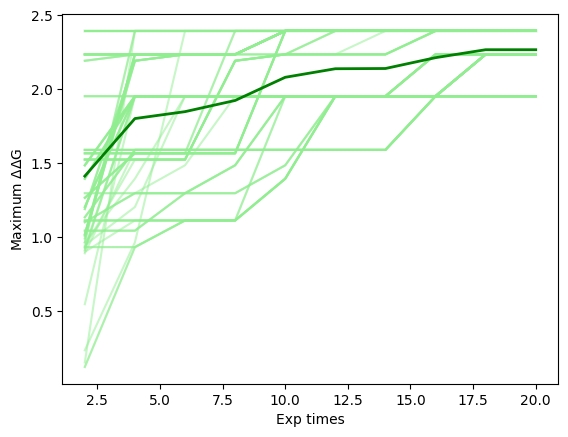

In [54]:
dist_ave_cur_best_arr = np.array(all_cur_best_lst).mean(0)
dist_ave_cur_match_best_arr = np.array(all_match_best_lig_lst).mean(0)
for cur_best_lst in all_cur_best_lst:
    plt.plot(exp_times,cur_best_lst,c='lightgreen',alpha=0.5)
plt.plot(exp_times,dist_ave_cur_best_arr,c='green',linewidth=2)
plt.xlabel('Exp times')
plt.ylabel('Maximum $\Delta$$\Delta$G')

Text(0, 0.5, 'Match best ratio')

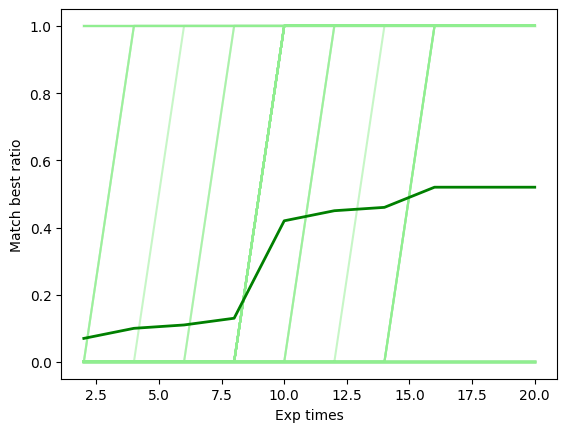

In [55]:
for match_best_lig_lst in all_match_best_lig_lst:
    plt.plot(exp_times,match_best_lig_lst,c='lightgreen',alpha=0.5)
    
plt.plot(exp_times,dist_ave_cur_match_best_arr,c='green',linewidth=2)
plt.xlabel('Exp times')
plt.ylabel('Match best ratio')

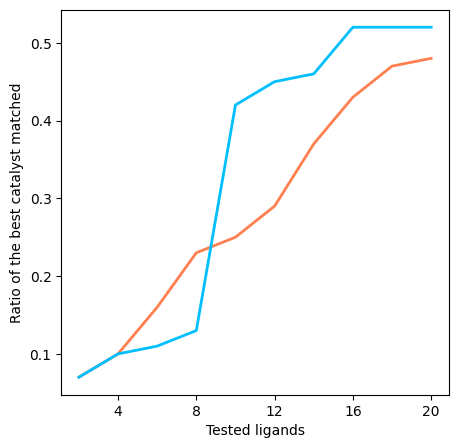

In [56]:
plt.figure(figsize=(5,5))
plt.plot(exp_times,rand_ave_cur_match_best_arr,c='coral',linewidth=2)
plt.plot(exp_times,dist_ave_cur_match_best_arr,c='deepskyblue',linewidth=2)
plt.xlabel('Tested ligands')
plt.ylabel('Ratio of the best catalyst matched')
plt.xticks([4,8,12,16,20],['4','8','12','16','20'])
print()
#plt.xticks([0,2,4,6,8,10],['0','2','4','6','8','10'])
#plt.yticks([0.1,0.15,0.2,0.25,0.3,0.35,0.4],["0.10","0.15","0.20","0.25","0.30","0.35","0.40"])

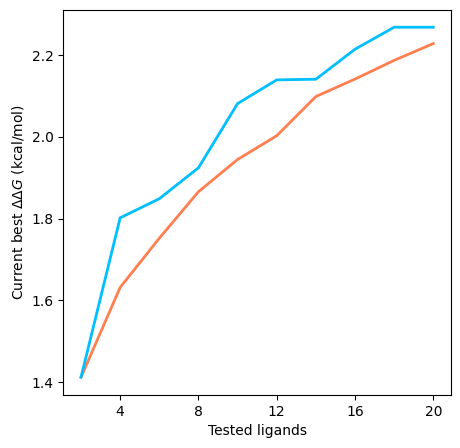

In [57]:
plt.figure(figsize=(5,5))
plt.plot(exp_times,rand_ave_cur_best_arr,c='coral',linewidth=2)
plt.plot(exp_times,dist_ave_cur_best_arr,c='deepskyblue',linewidth=2)
plt.xlabel('Tested ligands')
plt.ylabel('Current best $\Delta$$\Delta$$G$ (kcal/mol)')
plt.xticks([4,8,12,16,20],['4','8','12','16','20'])
print()
#plt.xticks([0,2,4,6,8,10],['0','2','4','6','8','10'])
#plt.yticks([0.1,0.15,0.2,0.25,0.3,0.35,0.4],["0.10","0.15","0.20","0.25","0.30","0.35","0.40"])

#### 推高选择性配体 (这部分没有用新模型重跑)

每个配体一个平均分数

In [ ]:
cat_selectivity_map = {}
for cat,ddg in zip(cat_lst,label):
    if cat in cat_selectivity_map:
        cat_selectivity_map[cat].append(abs(ddg))
    else:
        cat_selectivity_map[cat] = [abs(ddg)]
cat_selectivity_score_lst = sorted([[cat,np.mean(ddg_lst)] for cat,ddg_lst in cat_selectivity_map.items()],key=lambda x:x[1])

In [ ]:
plt.hist([item[1] for item in cat_selectivity_score_lst])

In [ ]:
batch_size = 2
leave_best_topk = 3
rand_seed = 5

cur_score,cur_cat,pool_cat = random_init(cat_selectivity_score_lst,leave_best_topk=leave_best_topk,batch_size=batch_size,rand_seed=rand_seed)
cur_score,cur_cat,pool_cat = recommend_by_dist(catemb_calc,cur_score,cur_cat,pool_cat,batch_size=batch_size)
cur_score,cur_cat,pool_cat = recommend_by_dist(catemb_calc,cur_score,cur_cat,pool_cat,batch_size=batch_size)
cur_score,cur_cat,pool_cat = recommend_by_dist(catemb_calc,cur_score,cur_cat,pool_cat,batch_size=batch_size)

In [ ]:
batch_size = 2
leave_best_topk = 20
recommend_time = 4
test_time = 100


all_cur_best_lst = []
for i in range(test_time):

    cur_best_lst = []
    exp_times = []
    cur_score,cur_cat,pool_cat = random_init(cat_selectivity_score_lst,leave_best_topk=leave_best_topk,batch_size=batch_size,rand_seed=i)
    cur_best_lst.append(max(cur_score))
    exp_times.append(len(cur_score))
    for _ in range(recommend_time):
        cur_score,cur_cat,pool_cat = recommend_by_random(cur_score,cur_cat,pool_cat,batch_size=batch_size)
        cur_best_lst.append(max(cur_score))
        exp_times.append(len(cur_score))
    all_cur_best_lst.append(cur_best_lst)

In [ ]:
ave_cur_best_arr = np.array(all_cur_best_lst).mean(0)
for cur_best_lst in all_cur_best_lst:
    plt.plot(exp_times,cur_best_lst,c='lightblue',alpha=0.5)
plt.plot(exp_times,ave_cur_best_arr,c='blue',linewidth=2)
plt.xlabel('Exp times')
plt.ylabel('Maximum ${\Delta}$${\Delta}$$\it{G}$ (kcal/mol)')

In [ ]:
all_cur_best_lst = []
for i in range(test_time):

    cur_best_lst = []
    exp_times = []
    cur_score,cur_cat,pool_cat = random_init(cat_selectivity_score_lst,leave_best_topk=leave_best_topk,batch_size=batch_size,rand_seed=i)
    cur_best_lst.append(max(cur_score))
    exp_times.append(len(cur_score))
    for _ in range(recommend_time):
        cur_score,cur_cat,pool_cat = recommend_by_dist(catemb_calc,cur_score,cur_cat,pool_cat,batch_size=batch_size)
        cur_best_lst.append(max(cur_score))
        exp_times.append(len(cur_score))
    all_cur_best_lst.append(cur_best_lst)

In [ ]:
ave_cur_best_arr = np.array(all_cur_best_lst).mean(0)
for cur_best_lst in all_cur_best_lst:
    plt.plot(exp_times,cur_best_lst,c='lightgreen',alpha=0.5)
plt.plot(exp_times,ave_cur_best_arr,c='green',linewidth=2)
plt.xlabel('Exp times')
plt.ylabel('Maximum ${\Delta}$${\Delta}$$\it{G}$ (kcal/mol)')

一个产物一个产物来

0

In [ ]:
pdt_idx = 0
pdt_set = sorted(list(set(pdt_lst)))
pdt_smi = pdt_set[pdt_idx]

sel_cat_lst = [cat_lst[idx] for idx in range(len(cat_lst)) if pdt_lst[idx] == pdt_smi]
sel_ddG_lst = [label[idx] for idx in range(len(label)) if pdt_lst[idx] == pdt_smi]
print(len(sel_cat_lst),len(sel_ddG_lst))

cat_selectivity_score_lst = sorted([[cat,abs(ddG)] for cat,ddG in zip(sel_cat_lst,sel_ddG_lst)],key=lambda x:x[1])

In [ ]:
batch_size = 2
leave_best_topk = 20
recommend_time = 4
test_time = 100


all_cur_best_lst = []
for i in range(test_time):

    cur_best_lst = []
    exp_times = []
    cur_score,cur_cat,pool_cat = random_init(cat_selectivity_score_lst,leave_best_topk=leave_best_topk,batch_size=batch_size,rand_seed=i)
    cur_best_lst.append(max(cur_score))
    exp_times.append(len(cur_score))
    for _ in range(recommend_time):
        cur_score,cur_cat,pool_cat = recommend_by_random(cur_score,cur_cat,pool_cat,batch_size=batch_size)
        cur_best_lst.append(max(cur_score))
        exp_times.append(len(cur_score))
    all_cur_best_lst.append(cur_best_lst)

In [ ]:
ave_cur_best_arr = np.array(all_cur_best_lst).mean(0)
for cur_best_lst in all_cur_best_lst:
    plt.plot(exp_times,cur_best_lst,c='lightblue',alpha=0.5)
ave_cur_best_arr_random = deepcopy(ave_cur_best_arr)
plt.plot(exp_times,ave_cur_best_arr,c='blue',linewidth=2)
plt.xlabel('Exp times')
plt.ylabel('Maximum ${\Delta}$${\Delta}$$\it{G}$ (kcal/mol)')

In [ ]:
all_cur_best_lst = []
for i in range(test_time):

    cur_best_lst = []
    exp_times = []
    cur_score,cur_cat,pool_cat = random_init(cat_selectivity_score_lst,leave_best_topk=leave_best_topk,batch_size=batch_size,rand_seed=i)
    cur_best_lst.append(max(cur_score))
    exp_times.append(len(cur_score))
    for _ in range(recommend_time):
        cur_score,cur_cat,pool_cat = recommend_by_dist(catemb_calc1,cur_score,cur_cat,pool_cat,batch_size=batch_size)
        cur_best_lst.append(max(cur_score))
        exp_times.append(len(cur_score))
    all_cur_best_lst.append(cur_best_lst)

In [ ]:
ave_cur_best_arr = np.array(all_cur_best_lst).mean(0)
for cur_best_lst in all_cur_best_lst:
    plt.plot(exp_times,cur_best_lst,c='lightgreen',alpha=0.5)
ave_cur_best_arr_dist = deepcopy(ave_cur_best_arr)
plt.plot(exp_times,ave_cur_best_arr,c='green',linewidth=2)
plt.xlabel('Exp times')
plt.ylabel('Maximum ${\Delta}$${\Delta}$$\it{G}$ (kcal/mol)')

In [ ]:
plt.plot(exp_times,ave_cur_best_arr_random,c='blue',linewidth=2)
plt.plot(exp_times,ave_cur_best_arr_dist,c='green',linewidth=2)
plt.xlabel('Exp times')
plt.ylabel('Maximum ${\Delta}$${\Delta}$$\it{G}$ (kcal/mol)')

1

In [ ]:
pdt_idx = 1
pdt_set = sorted(list(set(pdt_lst)))
pdt_smi = pdt_set[pdt_idx]

sel_cat_lst = [cat_lst[idx] for idx in range(len(cat_lst)) if pdt_lst[idx] == pdt_smi]
sel_ddG_lst = [label[idx] for idx in range(len(label)) if pdt_lst[idx] == pdt_smi]
print(len(sel_cat_lst),len(sel_ddG_lst))

cat_selectivity_score_lst = sorted([[cat,abs(ddG)] for cat,ddG in zip(sel_cat_lst,sel_ddG_lst)],key=lambda x:x[1])

In [ ]:
batch_size = 2
leave_best_topk = 20
recommend_time = 4
test_time = 100


all_cur_best_lst = []
for i in range(test_time):

    cur_best_lst = []
    exp_times = []
    cur_score,cur_cat,pool_cat = random_init(cat_selectivity_score_lst,leave_best_topk=leave_best_topk,batch_size=batch_size,rand_seed=i)
    cur_best_lst.append(max(cur_score))
    exp_times.append(len(cur_score))
    for _ in range(recommend_time):
        cur_score,cur_cat,pool_cat = recommend_by_random(cur_score,cur_cat,pool_cat,batch_size=batch_size)
        cur_best_lst.append(max(cur_score))
        exp_times.append(len(cur_score))
    all_cur_best_lst.append(cur_best_lst)

ave_cur_best_arr_random = np.array(all_cur_best_lst).mean(0)



all_cur_best_lst = []
for i in range(test_time):

    cur_best_lst = []
    exp_times = []
    cur_score,cur_cat,pool_cat = random_init(cat_selectivity_score_lst,leave_best_topk=leave_best_topk,batch_size=batch_size,rand_seed=i)
    cur_best_lst.append(max(cur_score))
    exp_times.append(len(cur_score))
    for _ in range(recommend_time):
        cur_score,cur_cat,pool_cat = recommend_by_dist(catemb_calc1,cur_score,cur_cat,pool_cat,batch_size=batch_size)
        cur_best_lst.append(max(cur_score))
        exp_times.append(len(cur_score))
    all_cur_best_lst.append(cur_best_lst)
    
ave_cur_best_arr_dist = np.array(all_cur_best_lst).mean(0)

In [ ]:
plt.plot(exp_times,ave_cur_best_arr_random,c='blue',linewidth=2)
plt.plot(exp_times,ave_cur_best_arr_dist,c='green',linewidth=2)
plt.xlabel('Exp times')
plt.ylabel('Maximum ${\Delta}$${\Delta}$$\it{G}$ (kcal/mol)')

### 评估催化剂/配体相似性，用于推荐新的催化剂/配体

#### XXY

In [8]:
rxn_data1 = pd.read_csv('../dataset/rxn_data/xxy/lit_data_with_cplex_smi.csv')
rxn_data2 = pd.read_csv('../dataset/rxn_data/xxy/com_data_with_cplex_smi.csv')
lig_lib = np.load("../dataset/rxn_data/xxy/smi_sascore_map.npy",allow_pickle=True).item()
sel_lig_lib_by_sascore = {k: v for k, v in lig_lib.items() if v < 4}
sel_lig_lib_by_sascore_lst = list(sel_lig_lib_by_sascore.keys())
existed_lig_smi_lst = rxn_data2['lig_smi'].to_list()
remain_lig_smi_lst = list(set(sel_lig_lib_by_sascore_lst) - set(existed_lig_smi_lst))
ddg_arr = rxn_data2['ddG'].to_numpy()
ee_arr = rxn_data2['ee'].to_numpy()

best_topk_lig_idx_lst = np.abs(ee_arr).argsort()[::-1][:1]
worst_topk_lst_idx_lst = np.abs(ee_arr).argsort()[:2]
print(ee_arr[best_topk_lig_idx_lst],ee_arr[worst_topk_lst_idx_lst])

tgt_lig_smi_ddg_map = {'CC(C)(C)[S@@](=O)N(Cc1ccccc1)[C@H](CP(c1ccccc1)c1ccccc1)c1ccccc1':0.91,
                       'Cc1ccc([C@@H](CP(c2ccccc2)c2ccccc2)N(Cc2ccccc2)[S@](=O)C(C)(C)C)cc1':0.88,
                       'Cc1ccc(CN([C@H](CP(c2ccccc2)c2ccccc2)c2ccccc2)[S@](=O)C(C)(C)C)cc1':0.93}

[0.66] [0.01 0.01]


In [7]:
len(existed_lig_smi_lst),len(remain_lig_smi_lst)

(21, 4600)

In [25]:
rxn_data2['lig_smi'].to_numpy()[best_topk_lig_idx_lst]

array(['CN([C@H](CP(c1ccccc1)c1ccccc1)c1ccccc1)[S@](=O)C(C)(C)C'],
      dtype=object)

##### 从配体出发

In [26]:
existed_lig_desc_arr = catemb_calc.gen_desc(existed_lig_smi_lst)
remain_lig_desc_arr = catemb_calc.gen_desc(remain_lig_smi_lst)

In [27]:
best_existed_lig_desc_arr = existed_lig_desc_arr[best_topk_lig_idx_lst]
worst_existed_lig_desc_arr = existed_lig_desc_arr[worst_topk_lst_idx_lst]
dist_of_remain_to_best = np.array([np.linalg.norm(arr - remain_lig_desc_arr,axis=1) for arr in best_existed_lig_desc_arr])
dist_of_remain_to_worst = np.array([np.linalg.norm(arr - remain_lig_desc_arr,axis=1) for arr in worst_existed_lig_desc_arr])

dist_score = dist_of_remain_to_best.sum(0)# - dist_of_remain_to_worst.sum(0)  ## 越小越好

for smi in list(tgt_lig_smi_ddg_map.keys()):
    if smi in np.array(remain_lig_smi_lst)[dist_score.argsort()[:10]].tolist():
        print(smi)
        
remain_smi_dist_score_lst = sorted([[smi,score] for smi,score in zip(remain_lig_smi_lst,dist_score)],key=lambda x:x[1])
for idx,item in enumerate(remain_smi_dist_score_lst):
    if item[0] in tgt_lig_smi_ddg_map.keys():
        print(idx,item)

CC(C)(C)[S@@](=O)N(Cc1ccccc1)[C@H](CP(c1ccccc1)c1ccccc1)c1ccccc1
5 ['CC(C)(C)[S@@](=O)N(Cc1ccccc1)[C@H](CP(c1ccccc1)c1ccccc1)c1ccccc1', np.float32(0.3381071)]
126 ['Cc1ccc(CN([C@H](CP(c2ccccc2)c2ccccc2)c2ccccc2)[S@](=O)C(C)(C)C)cc1', np.float32(0.5670339)]
131 ['Cc1ccc([C@@H](CP(c2ccccc2)c2ccccc2)N(Cc2ccccc2)[S@](=O)C(C)(C)C)cc1', np.float32(0.5688443)]


##### 从催化剂出发

In [28]:
sadphos_smarts_idx_map = {
                      '[*][CX4;!R]([CX4;!R][PX3]([#6])[#6])N([*])[S@@X3]([*])=O': [3,8], # P, S
                      'PccCN([*])[S@@X3]([*])=O':[0,6]
                      }
sadphos_smi_scaffold_map = {k: Chem.MolFromSmarts(k) for k,v in sadphos_smarts_idx_map.items()}
lig_smi_cat_smi_map = {}
for smi in remain_lig_smi_lst+existed_lig_smi_lst:
    mol = Chem.MolFromSmiles(smi)
    match_ = False
    for scaffold_smi in sadphos_smi_scaffold_map.keys():
        scaffold = sadphos_smi_scaffold_map[scaffold_smi]
        atom_idx = sadphos_smarts_idx_map[scaffold_smi]
        if mol.HasSubstructMatch(scaffold):
            match_ = True
            match_idx = mol.GetSubstructMatch(scaffold)
            coord_at_idx_lst = [match_idx[idx] for idx in atom_idx]
            coord_at_types = [mol.GetAtomWithIdx(idx).GetSymbol() for idx in coord_at_idx_lst]
            assert 'P' in coord_at_types and 'S' in coord_at_types
            cat_mol = link_lig_to_metal(mol,'Ni',coord_at_idx_lst,2)
            lig_smi_cat_smi_map[smi] = Chem.MolToSmiles(cat_mol)
            break
    if not match_:
        print(smi)


In [29]:
remain_cat_smi_lst = [lig_smi_cat_smi_map[smi] for smi in remain_lig_smi_lst]
existed_cat_smi_lst = [lig_smi_cat_smi_map[smi] for smi in existed_lig_smi_lst]

In [30]:
existed_cat_desc_arr = catemb_calc.gen_desc(existed_cat_smi_lst)
remain_cat_desc_arr = catemb_calc.gen_desc(remain_cat_smi_lst)

In [31]:
best_existed_cat_desc_arr = existed_cat_desc_arr[best_topk_lig_idx_lst]
worst_existed_cat_desc_arr = existed_cat_desc_arr[worst_topk_lst_idx_lst]
dist_of_remain_to_best = np.array([np.linalg.norm(arr - remain_cat_desc_arr,axis=1) for arr in best_existed_cat_desc_arr])
dist_of_remain_to_worst = np.array([np.linalg.norm(arr - remain_cat_desc_arr,axis=1) for arr in worst_existed_cat_desc_arr])

dist_score = dist_of_remain_to_best.sum(0)# - dist_of_remain_to_worst.sum(0)  ## 越小越好

for smi in list(tgt_lig_smi_ddg_map.keys()):
    if smi in np.array(remain_lig_smi_lst)[dist_score.argsort()[:10]].tolist():
        print(smi)
        
remain_smi_dist_score_lst = sorted([[smi,score] for smi,score in zip(remain_lig_smi_lst,dist_score)],key=lambda x:x[1])
for idx,item in enumerate(remain_smi_dist_score_lst):
    if item[0] in tgt_lig_smi_ddg_map.keys():
        print(idx,item)

CC(C)(C)[S@@](=O)N(Cc1ccccc1)[C@H](CP(c1ccccc1)c1ccccc1)c1ccccc1
5 ['CC(C)(C)[S@@](=O)N(Cc1ccccc1)[C@H](CP(c1ccccc1)c1ccccc1)c1ccccc1', np.float32(0.33443776)]
98 ['Cc1ccc(CN([C@H](CP(c2ccccc2)c2ccccc2)c2ccccc2)[S@](=O)C(C)(C)C)cc1', np.float32(0.5469437)]
100 ['Cc1ccc([C@@H](CP(c2ccccc2)c2ccccc2)N(Cc2ccccc2)[S@](=O)C(C)(C)C)cc1', np.float32(0.54929507)]


In [ ]:
import numpy as np
import torch
from catemb.model import CL2D3DMol
from catemb.data import CatDataset,get_idx_split
from catemb.train import CLTrain
from torch_geometric.loader import DataLoader
from torch_scatter import scatter
import matplotlib.pyplot as plt
from catemb.loss import dual_CL
from torch.nn import MSELoss
from copy import deepcopy
mse_loss = MSELoss()

In [ ]:
model_path = "./save_model/260122-0214h_equif_reduceonplateau_lr1e-4_temp0.1_EBM_dot_prod_xtbopt178674_equif_first_dim64_noLN"
full_params = np.load(f"{model_path}/full_params.npy",allow_pickle=True).item()
model_params = torch.load(f"{model_path}/best_model.pt", map_location=torch.device('cpu'))

In [ ]:
param_data = full_params['param_data']
param_other = full_params['param_other']
dataset = CatDataset(**param_data,seed=param_other['seed'])

data_split_dict = get_idx_split(len(dataset),
                                int(param_data['train_ratio']*len(dataset)),
                                int(param_data['valid_ratio']*len(dataset)),seed=param_other['seed'])
train_dataset = dataset[data_split_dict['train']]
valid_dataset = dataset[data_split_dict['valid']]

valid_dataloader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

In [ ]:
full_params.keys()

In [ ]:
clmodel = CL2D3DMol(param_2d=full_params['param_2d'], param_3d=full_params['param_3d'],reduce=full_params['param_cl']['reduce'])
clmodel.load_state_dict(model_params['model_state_dict'])
clmodel.eval()
clmodel.to(full_params['param_other']['device'])
print()

In [ ]:
with torch.no_grad():
    loss_accum = 0.
    cl_loss_accum = 0.
    kl_loss_accum = 0.
    energy_loss_accum = 0.
    mol_num = 0
    for step, data in enumerate(valid_dataloader):
        data = data.to(full_params['param_other']['device'])
        mol_feat_from_2d, mol_feat_from_3d, energy_p = clmodel(data)
        cl_loss, kl_loss = dual_CL(mol_feat_from_2d, mol_feat_from_3d, normalize=True, metric=full_params['param_cl']['metric'], T=full_params['param_cl']['T'],
                                    lambda_cl=full_params['param_cl']['cl_weight'], lambda_kl=full_params['param_cl']['kl_weight'])
        energy_loss = mse_loss(energy_p, data.E)
        loss = cl_loss * full_params['param_cl']['cl_weight'] + kl_loss * full_params['param_cl']['kl_weight'] + energy_loss * full_params['param_cl']['e_weight']
        
        loss_item = loss.detach().cpu().item()
        cl_loss_item = cl_loss.detach().cpu().item()
        kl_loss_item = kl_loss.detach().cpu().item()
        energy_loss_item = energy_loss.detach().cpu().item()
        
        mol_num += len(mol_feat_from_2d)
        loss_accum += loss_item
        cl_loss_accum += cl_loss_item
        kl_loss_accum += kl_loss_item
        energy_loss_accum += energy_loss_item
        
    loss_ave = loss_accum / mol_num
    cl_loss_ave = cl_loss_accum / mol_num
    kl_loss_ave = kl_loss_accum / mol_num
    energy_loss_ave = energy_loss_accum / mol_num
    print(f"Eval loss: {loss_ave:.4f}, cl loss: {cl_loss_ave:.4f}, kl loss: {kl_loss_ave:.6f}, energy loss: {energy_loss_ave:.4f}")

In [ ]:
atom_feat_2d = clmodel.graph_encoder_2d(data.x,data.edge_index,data.edge_attr)
atom_feat_from2d = clmodel.projection_from_2d(atom_feat_2d)
mol_feat_from_2d = scatter(atom_feat_from2d, data.batch, dim=0, reduce=clmodel.reduce)
cat_emb = mol_feat_from_2d.cpu().detach().numpy()

In [ ]:
data.smiles

In [ ]:
### 输入构造

In [ ]:
from catemb.data import build_graph_input

In [ ]:
smiles_lst = ['CN1[C@H](c2ccccc2)c2ccccc2[P](->[Ce]<-[S@@]1(=O)C(C)(C)C)(C1CCCCC1)C1CCCCC1',
 'CN([C@H](c1ccc2c(c1)C1c3ccccc3C2c2ccccc21)c1ccccc1[P](->[Mn])(C(C)(C)C)C(C)(C)C)[S@](=O)C(C)(C)C',
 'COc1cccc(OC)c1[C@@H]1N[S@@](=O)(->[Cr]<-[P](c2ccc(C(F)(F)F)cc21)(C1CCCCC1)C1CCCCC1)C(C)(C)C',
 'CC(C)c1cc(C(C)C)c(-c2ccccc2[C@H]2C[P](->[Sm]<-[S@](=O)(N2)C(C)(C)C)(c2ccccc2)c2ccccc2)c(C(C)C)c1']*100


dataloader = build_graph_input(smiles_lst,64)

In [ ]:
cat_emb_merge = []
for data_ in DataLoader(data_lst,batch_size=4):
    atom_feat_2d = clmodel.graph_encoder_2d(data.x,data.edge_index,data.edge_attr)
    atom_feat_from2d = clmodel.projection_from_2d(atom_feat_2d)
    mol_feat_from_2d = scatter(atom_feat_from2d, data.batch, dim=0, reduce=clmodel.reduce)
    cat_emb = mol_feat_from_2d.cpu().detach().numpy()
    cat_emb_merge.append(cat_emb)
cat_emb_merge = np.concatenate(cat_emb_merge,axis=0)

In [ ]:
cat_emb_merge.shape